<a href="https://colab.research.google.com/github/cyberest/KurlyHackathon/blob/main/2022_Kurly_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 통계적 이상치 탐지 기법을 활용한 물류 업무 불안전 행동(human error) 예방

[통계학개론]
박준영, 한결, 황근현

(최종수정일 2022.08.24)


#### 차례

In [181]:
"""
1. 사전 준비
    - 라이브러리 가져오기
    - 사용자 함수 정의
    - 데이터 가져오기

2. 탐색적 분석 및 전처리
    - 기술통계 및 분포 확인
    - 이상치 확인, 제거
    - 스케일링 (표준화)
    - 정규성 검정
    - 분석대상 구간 분할

3. 데이터 가공
    - 훈련-검증 데이터셋 분할
    - 서브샘플링

4. 독립변수 선택
    - 관측 데이터 (observed)
    - PCA(Principal Component Analysis)
    - 요인분석(Factor Analysis)

5. 모형 구축
    - 왜 로지스틱인가
    - 로지스틱 회귀계수의 해석
    - 일반 로지스틱 회귀
    - L2 제약 로지스틱 회귀
    - Multi-task learning 확장

6. 모형 평가

7. 서비스 적용
"""

'\n1. 사전 준비\n    - 라이브러리 가져오기\n    - 사용자 함수 정의\n    - 데이터 가져오기\n\n2. 탐색적 분석 및 전처리\n    - 기술통계 및 분포 확인\n    - 이상치 확인, 제거\n    - 스케일링 (표준화)\n    - 정규성 검정\n    - 분석대상 구간 분할\n\n3. 데이터 가공\n    - 훈련-검증 데이터셋 분할\n    - 서브샘플링\n\n4. 독립변수 선택\n    - 관측 데이터 (observed)\n    - PCA(Principal Component Analysis)\n    - 요인분석(Factor Analysis)\n\n5. 모형 구축\n    - 왜 로지스틱인가\n    - 로지스틱 회귀계수의 해석\n    - 일반 로지스틱 회귀\n    - L2 제약 로지스틱 회귀\n    - Multi-task learning 확장\n\n6. 모형 평가\n\n7. 서비스 적용\n'

### 1. 사전 준비

#### 라이브러리 가져오기

In [5]:
# 추가 모듈 설치
!pip install factor_analyzer pingouin pymysql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# 데이터 분석
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from factor_analyzer import FactorAnalyzer # 요인 분석
import pingouin as pg # 다변량 분석

pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.4f}'.format
random_state = 1
np.random.seed = random_state

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 성능평가
from timeit import default_timer as timer
from sklearn.metrics import mean_squared_error, log_loss, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

#### 사용자 정의 함수

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log


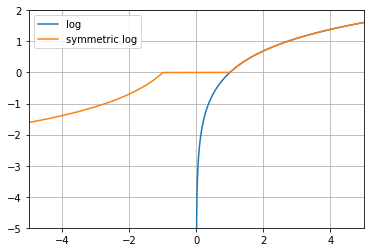

In [7]:
# 플롯 관련 함수

# 다변수 히스토그램 그리기
def plot_variable_hist(data, num_cols=4, sample_frac=0.1):
    print(f'전체 데이터 count: {len(data):,}')

    fig, axes = plt.subplots(ncols=num_cols, nrows=int(np.floor(len(data.columns)/num_cols))+1, figsize=(15,25))
    data = data.sample(frac=sample_frac, random_state=random_state)

    for idx, col in enumerate(data.columns):
        ax = axes.flatten()[idx]
        # bins_ = np.histogram_bin_edges(data[col], bins='auto') # object나 timestamp에서 오류 발생
        # sns.histplot(data=data[col], x=col, stat='count', bins=bins_, ax=ax)
        sns.histplot(data=data, x=col, stat='count', bins='auto', ax=ax)

    plt.tight_layout()
    plt.show()

# 음수 정의역에 대한 로그 함수 정의
# https://stackoverflow.com/questions/21610198/runtimewarning-divide-by-zero-encountered-in-log
def symmetric_log(x):
    with np.errstate(divide='ignore', invalid='ignore'):
        # 0이 주어지면 nan으로 반환: 표준화 여부를 알 수 없으므로 추후 별도 지정
        # 정의역 -1~1 구간은 0으로 지정
        return np.where(np.sign(x) == 1, np.maximum(np.log(x),0), np.where(np.sign(x) == 0, np.nan, np.minimum(-np.log(-x),0)))

x = np.linspace(-5, 5, 10000)

plt.plot(x, np.log(x), label='log')
plt.plot(x, symmetric_log(x), label='symmetric log')
plt.xlim(x.min(), x.max())
plt.ylim(-5, 2)

plt.grid(True)
plt.legend()
plt.show()

In [141]:
# 모형 평가 관련 함수

# 계산 비용효율 계산 및 표시
def computational_efficiency(effort, error, error_type='least_square', verbose=True):
    new_error = (1-error) if error_type == 'bias' else error # bias based, percentage measures like F1 score
    ce = 1/(effort * new_error)
    if verbose:
        print('Computational efficiency: ', ce)
    return ce

# 소요시간 표시
def print_time(time):
    print('Time taken (seconds): ', time)

def binary_f1_score(y_true, y_predict_binary):
    y_t = y_true
    y_p = y_predict_binary
    accuracy = accuracy_score(y_true=y_t, y_pred=y_p)
    precision = precision_score(y_true=y_t, y_pred=y_p, average='binary')
    recall = recall_score(y_true=y_t, y_pred=y_p, average='binary')
    f1 = f1_score(y_true=y_t, y_pred=y_p, average='binary')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# confusion matrix
def binary_conf_matrix(y_true, y_predict_binary):
    y_t = y_true
    y_p = y_predict_binary
    return confusion_matrix(y_t, y_p, labels=[1, 0])

# ROC 커브 데이터 생성
def binary_roc_curve_data(y_true, y_predict_prob):
    y_t = y_true
    y_p = y_predict_prob
    fpr, tpr, thresholds = roc_curve(y_true=y_t, y_score=y_p, drop_intermediate=True)
    # get optimal threshold maximizing auc
    optimal_cutoff_point = np.argmax(tpr-fpr)
    optimal_cutoff_value = thresholds[optimal_cutoff_point]
    return {
        'fpr': fpr, 
        'tpr': tpr, 
        'thresholds': thresholds, 
        'optimal_cutoff_point': optimal_cutoff_point, 
        'optimal_cutoff_value': optimal_cutoff_value,
    }

def binary_roc_curve_draw(roc_data, ax):
    fpr = roc_data['fpr']
    tpr = roc_data['tpr']
    thresholds = roc_data['thresholds']
    optimal_cutoff_point = roc_data['optimal_cutoff_point']
    optimal_cutoff_value = roc_data['optimal_cutoff_value']

    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label='ROC curve')
    ax.scatter(fpr[optimal_cutoff_point], tpr[optimal_cutoff_point], s=30, c='red', label='Optimal threshold')
    ax.annotate(f'{optimal_cutoff_value:.3f}', (fpr[optimal_cutoff_point], tpr[optimal_cutoff_point] - 0.05))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate\n(1-specificity)')
    ax.set_ylabel('True Positive Rate\n(sensitivity)')
    ax.set_title(f'ROC curve\n(AUC = {roc_auc:.2f})')
    ax.legend(loc="lower right")

#### 데이터 가져오기

In [9]:
# 분석대상 데이터셋: pickle 형태로 제공
# https://zenodo.org/record/4383145#.Yv85jexBydY
import cloudpickle as cp
from urllib.request import urlopen
link_url = "https://zenodo.org/record/4383145/files/feature_matrix.pickle?download=1"
fetched_dataset = cp.load(urlopen(link_url)) # returns DataFrame
raw_data = fetched_dataset
target = 'escalation_flag'

### 2. 탐색적 분석 및 전처리

#### 기술통계 확인

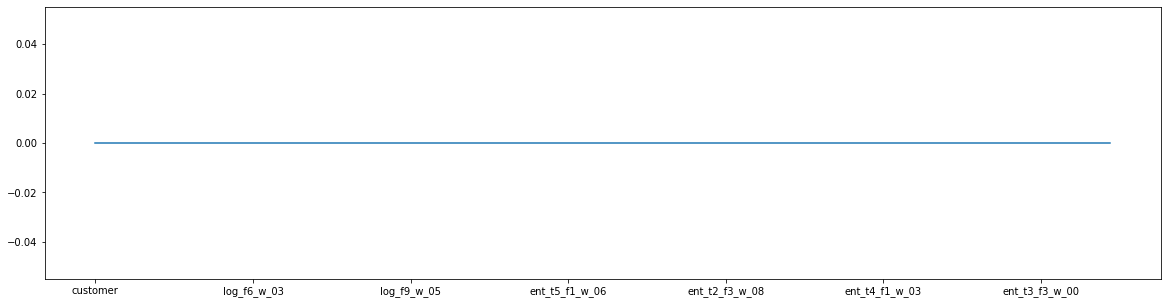

In [11]:
# 총 323개 featrue 중에서 누락 데이터 있는 변수는 없음
data = raw_data.copy()
data.isnull().sum().plot(figsize=(20,5))
plt.show()

In [12]:
# (독립변수) 극단치 확인
# - 변수별로 스케일이 천차만별이고
# - 애초에 변수(feature)의 수 자체가 너무 많은 상태
# 따라서 극단치 처리는 기본적인 데이터 전처리, 변수선택 및 표준화 이후 수행

data = raw_data.copy()
data.describe()

,log_f1_w_00,log_f5_w_00,log_f7_w_00,log_f9_w_00,log_f10_w_00,log_f11_w_00,log_f12_w_00,log_f13_w_00,log_f15_w_00,ent_t1_f1_w_00,...,log_f14_w_09,log_f14_w_08,log_f14_w_07,log_f14_w_06,log_f14_w_05,log_f14_w_04,log_f14_w_03,log_f14_w_02,log_f14_w_01,log_f14_w_00
count,106382.0000,106382.0000,106382.0000,106382.0000,106382.0000,106382.0000,106382.0000,106382.0000,106382.0000,106382.0000,...,106382.0000,106382.0000,106382.0000,106382.0000,106382.0000,106382.0000,106382.0000,106382.0000,106382.0000,106382.0000
mean,0.9240,3.6792,4.5336,3.9677,0.7461,0.5356,8.8272,4.3128,1.1006,49.6467,...,0.0367,0.0366,0.0362,0.0357,0.0352,0.0354,0.0347,0.0340,0.0335,0.0331
std,10.2406,4.3008,6.0888,4.7919,5.2238,2.6509,13.1842,6.2685,5.1768,40.0143,...,0.2918,0.2921,0.2913,0.2895,0.2878,0.3065,0.3049,0.3024,0.3013,0.2996
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.0000,3.0000,4.0000,3.0000,0.0000,0.0000,7.0000,3.0000,0.0000,47.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.0000,6.0000,7.0000,6.0000,0.0000,0.0000,13.0000,7.0000,1.0000,83.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,1201.0000,71.0000,258.0000,72.0000,406.0000,514.0000,534.0000,310.0000,456.0000,120.0000,...,31.0000,31.0000,31.0000,31.0000,31.0000,34.0000,34.0000,34.0000,34.0000,34.0000


In [13]:
# (종속변수) 이상치 분포
# 141건으로, 전체 레코드의 1.3%에 해당
# 즉, 이 데이터셋은 불균형 데이터(imbalanced data)의 특징을 지님

data = raw_data.copy()
data[target].value_counts()

0.0000    106241
1.0000       141
Name: escalation_flag, dtype: int64

#### 0 값 제거

- 해당 데이터셋을 분석대상으로 삼은 논문에 따르면, 해당 데이터는 일정한 규칙을 갖고 주 단위로 쪼개져 있음
- 그러나 상당수 데이터가 count 성격을 지녀 0의 비율이 너무 높음
- 주 단위로 쪼개져 있는 feature를 10주 단위로 병합처리하여 사용

[참고] \\
A. Nguyen et al., "System Design for a Data-Driven and Explainable Customer Sentiment Monitor Using IoT and Enterprise Data," in IEEE Access, vol. 9, pp. 117140-117152, 2021, doi: 10.1109/ACCESS.2021.3106791.
https://ieeexplore.ieee.org/document/9520354

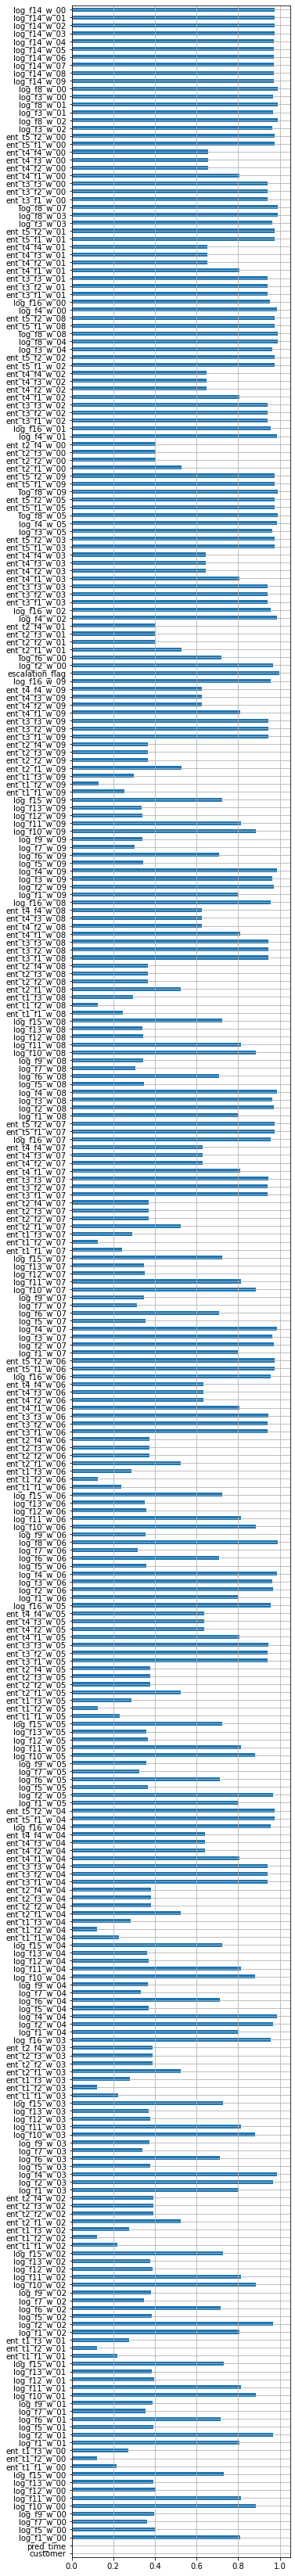

In [14]:
# 0이 차지하는 비율 높은 변수가 너무 많음
# 상당수 변수가 count 성격을 지니는 것으로 추정되기 때문 (ex - 기간 중 고객 문의 인입건수)

# 회귀분석은 독립변수의 특정 분포를 가정하지 않으므로 데이터 사용은 가능하나,
# 다중공선성으로 인해 회귀계수의 유의성이 낮아지는 문제 발생할 것

# PCA 등의 차원축소기법은 변수간의 선형관계와 각 변수의 정규분포 근사를 전제로 함
# 이대로 차원축소 기법인 PCA를 사용할 경우 주성분간의 독립성이 만족되기 어려움
data = raw_data.copy()
(data[data==0].count(axis=0)/len(data.index)).plot(figsize=(5,60), kind='barh', grid=True)
plt.show()

In [15]:
# 해당 데이터셋을 분석한 논문에 따르면, 해당 데이터는 일정한 규칙을 갖고 주 단위로 쪼개져 있다고 함
# 실제로 w_09에서부터 w_00로 데이터가 lagging되면서 전달되는 구조임을 확인할 수 있음
# 따라서 lagging 정보가 포함된 컬럼을 제거하여 0의 비율을 줄일 수 있음

# pred_time 1996-14 은 1996년 14주차 데이터를 의미하는 것으로 추정되며
# 1996-13 row 에서의 w_01 데이터가 1996-14 row 에서의 w_00 데이터가 됨
data = raw_data.copy()
data = data.iloc[:, data.columns.str.startswith('ent_t2_f2_w_')]
data = data.reindex(sorted(data.columns), axis=1)
data.insert(0, 'pred_time', raw_data['pred_time'])
data

,pred_time,ent_t2_f2_w_00,ent_t2_f2_w_01,ent_t2_f2_w_02,ent_t2_f2_w_03,ent_t2_f2_w_04,ent_t2_f2_w_05,ent_t2_f2_w_06,ent_t2_f2_w_07,ent_t2_f2_w_08,ent_t2_f2_w_09
0,1996-13,2.6143,2.6000,2.6000,2.5714,2.5952,2.6667,2.6667,2.6667,2.6667,2.6667
1,1996-14,2.6000,2.6000,2.5714,2.5952,2.6667,2.6667,2.6667,2.6667,2.6667,2.6905
2,1996-15,2.6000,2.5714,2.5952,2.6667,2.6667,2.6667,2.6667,2.6667,2.6905,2.5143
3,1996-16,2.5714,2.5952,2.6667,2.6667,2.6667,2.6667,2.6667,2.6905,2.5143,2.5000
4,1996-17,2.5952,2.6667,2.6667,2.6667,2.6667,2.6667,2.6905,2.5143,2.5000,2.5000
...,...,...,...,...,...,...,...,...,...,...,...
106377,1998-09,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
106378,1998-10,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
106379,1998-11,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
106380,1998-12,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [16]:
# 주 단위로 쪼개져 있는 feature를 10주 단위로 누적 합산(rolling sum)
# 즉, 각 변수마다 10개씩 컬럼으로 표현되어 있던 10주간의 데이터를 하나로 합쳐 1개 컬럼씩만 남김
data = raw_data.copy()
lastest_columns = data.iloc[:, data.columns.str.endswith('w_09')]
for col in lastest_columns.columns:
    col_family = data.iloc[:, data.columns.str.startswith(col.replace('w_09',''))]
    data[col.replace('_w_09','')] = col_family.sum(axis=1)
    data.drop(columns=col_family.columns, inplace=True)

lumpsum_data = data.copy()

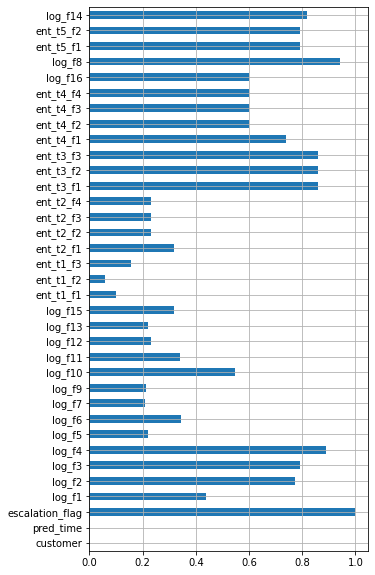

Index(['escalation_flag', 'log_f4', 'ent_t3_f1', 'ent_t3_f2', 'ent_t3_f3',
       'log_f8', 'log_f14'],
      dtype='object')


In [17]:
# 컬럼 통합 뒤 0의 비율을 다시 체크
data = lumpsum_data.copy()
zero_in_column = data[data==0].count(axis=0)/len(data.index)
zero_in_column.plot(figsize=(5,10), kind='barh', grid=True)
plt.show()

# 그래도 0의 비율이 80%를 넘는 열이 확인됨
print(zero_in_column[zero_in_column > 0.8].index)

In [18]:
data = lumpsum_data.copy()

# [불필요한 변수 제거]
# 종속변수(escalation_flag)를 제외하고 여전히 0의 비율이 80% 이상인 변수는 분석 대상에서 원천적으로 제외
data.drop(columns=['log_f4', 'ent_t3_f1', 'ent_t3_f2', 'ent_t3_f3', 'log_f8', 'log_f14'], inplace=True)

# [변수 데이터타입 바로잡기]
# Year-Weeknum 을 해당 주의 마지막 날짜로 변환
data['pred_time'] = pd.to_datetime('0-' + data['pred_time'], format='%w-%Y-%W') + pd.DateOffset(days=7)

var_select_data = data.copy()
var_select_data.dtypes

customer                   object
pred_time          datetime64[ns]
escalation_flag           float64
log_f1                    float64
log_f2                    float64
log_f3                    float64
log_f5                      int64
log_f6                    float64
log_f7                      int64
log_f9                      int64
log_f10                     int64
log_f11                     int64
log_f12                   float64
log_f13                     int64
log_f15                     int64
ent_t1_f1                   int64
ent_t1_f2                   int64
ent_t1_f3                   int64
ent_t2_f1                 float64
ent_t2_f2                 float64
ent_t2_f3                 float64
ent_t2_f4                 float64
ent_t4_f1                 float64
ent_t4_f2                 float64
ent_t4_f3                 float64
ent_t4_f4                 float64
log_f16                   float64
ent_t5_f1                 float64
ent_t5_f2                 float64
dtype: object

#### 분포 확인

전체 데이터 count: 106,382


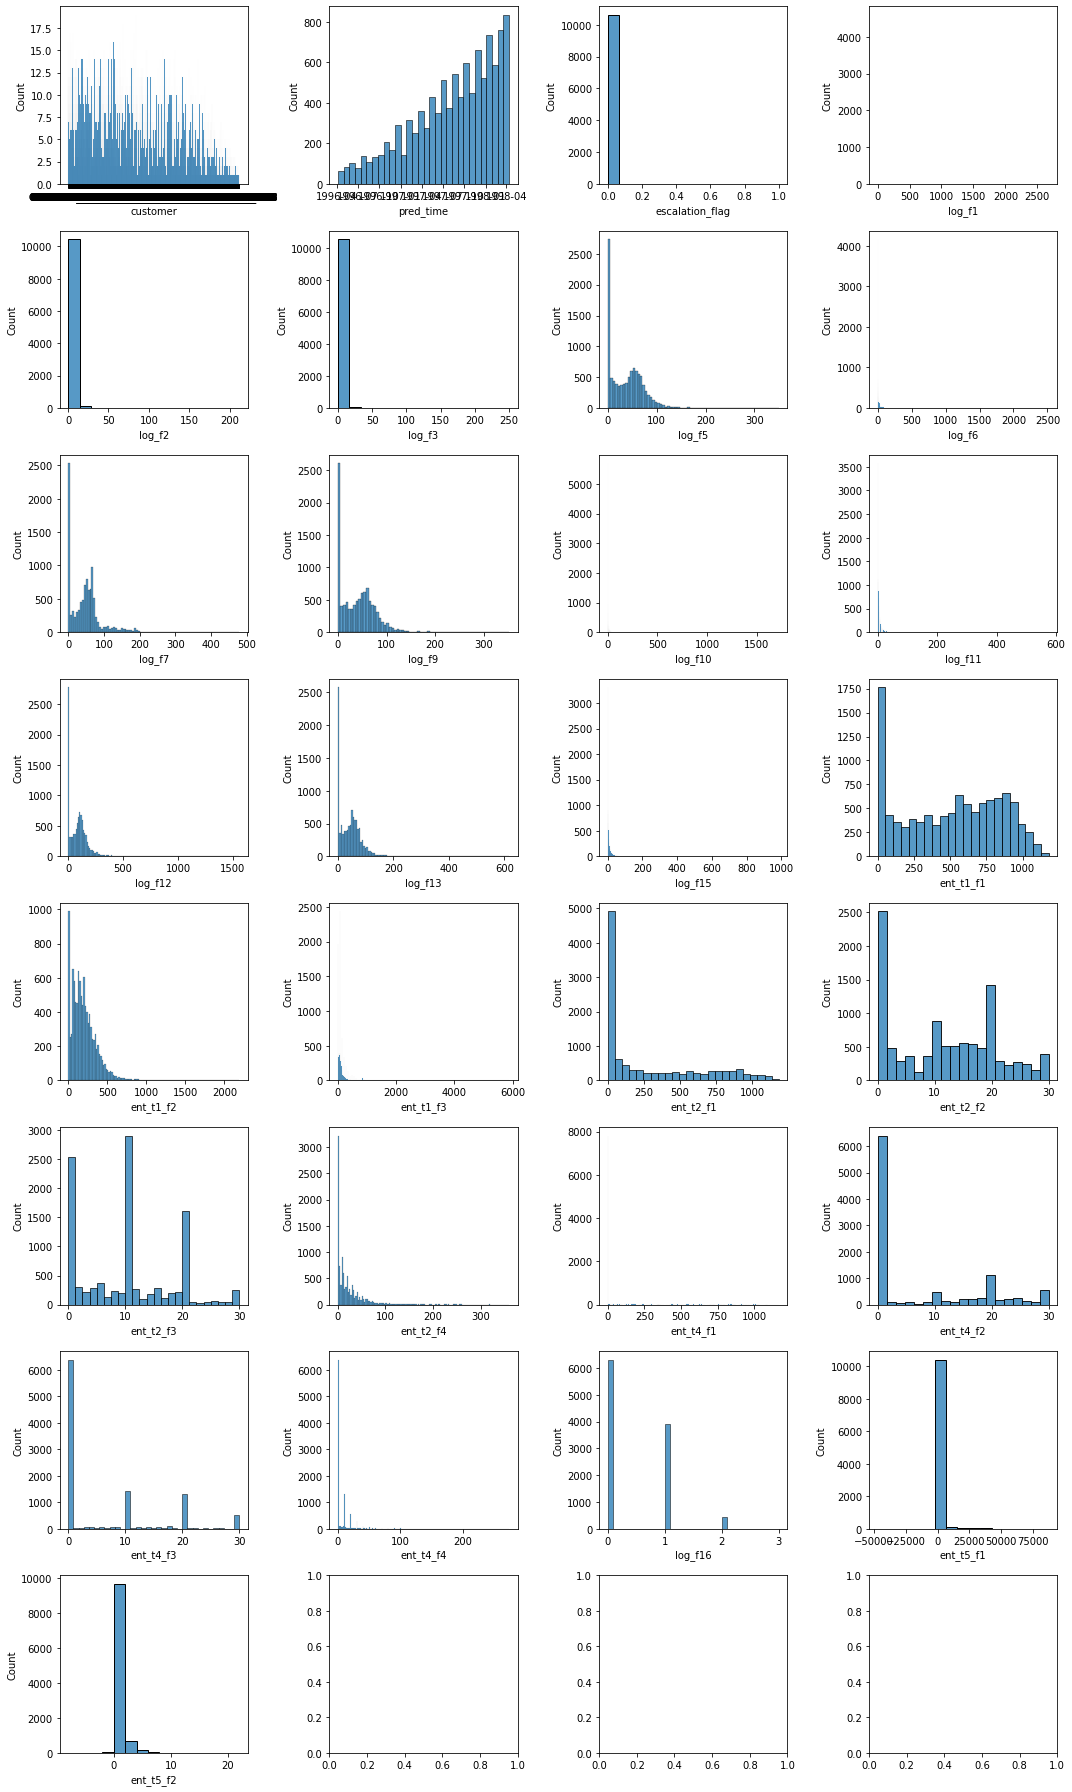

In [19]:
# 개략적인 독립변수 분포 확인
# - 정보량이 적은 변수를 제거했음에도 불구하고 여전히 0이 많은 상황
# - pred_time의 분포를 보면 최근으로 올수록 데이터가 더 많이 쌓이고 있음
# - 분포가 시각적으로 확인되지 않는 변수는 극단치가 존재하는 것으로 추정됨

data = var_select_data.copy()

plot_variable_hist(data)

In [20]:
# pred_time의 분포를 보면 최근으로 올수록 데이터가 더 많이 쌓이고 있음
# 특정 구간에 대해 더 많은 표본을 사용하면 모델에 더 큰 가중치가 실리게 됨
# 우리가 원하는 것은 전체 기간에 대해 일정한 가중치이므로 최근 데이터 중 일부를 랜덤으로 제거 (서브샘플링)
data = var_select_data.copy()

# 날짜 카운트의 역수를 가중치로 샘플링
data['pred_time_count'] = data.groupby(['pred_time'])['customer'].transform('count')
print(f'가장 빈도가 높은 날짜: {data["pred_time"][data["pred_time_count"].argmax()]}, 빈도 수: {data["pred_time_count"].max()}')
print(f'가장 빈도가 낮은 날짜: {data["pred_time"][data["pred_time_count"].argmin()]}, 빈도 수: {data["pred_time_count"].min()}')

# 빈도수가 10배 이상 차이가 나므로 서브샘플링 하더라도 완벽히 동일 가중치 데이터를 얻기 어렵지만 상당 부분 완화시킬 수 있음
time_adjusted_data = data.sample(frac=0.5, weights=1/data['pred_time_count'])
time_adjusted_data.drop(columns='pred_time_count', inplace=True)

print(f'전체 {len(data):,}개의 레코드 중 {len(time_adjusted_data):,}개의 레코드 남음 ({len(time_adjusted_data)/len(data):.0%})')

가장 빈도가 높은 날짜: 1998-04-12 00:00:00, 빈도 수: 2118
가장 빈도가 낮은 날짜: 1996-04-07 00:00:00, 빈도 수: 187
전체 106,382개의 레코드 중 53,191개의 레코드 남음 (50%)


In [21]:
# 분포상 여전히 0이 많은 상황
# (한 레코드 내에서) 0값이 너무 많으면 변수간의 다중공선성 또한 커지므로 미리 제거해야 함
# 0값이 너무 많은 (=정보량이 낮은) 레코드를 분석대상에서 제외
data = time_adjusted_data.copy()

# 0값을 갖는 컬럼이 전체 컬럼의 20% 이상인 경우를 제거한 데이터셋
zero_ratio = (data==0).astype(int).sum(axis=1)/len(data.columns) # 전체 열 중 값이 0인 열의 비율
records_to_remove = zero_ratio[zero_ratio > 0.2]
data.drop(index=records_to_remove.index, inplace=True)

zero_reduce_data = data.copy()
print(f'전체 {len(time_adjusted_data):,}개의 레코드 중 {len(data):,}개의 레코드 남음 ({len(data)/len(time_adjusted_data):.0%})')

전체 53,191개의 레코드 중 9,588개의 레코드 남음 (18%)


전체 데이터 count: 9,588


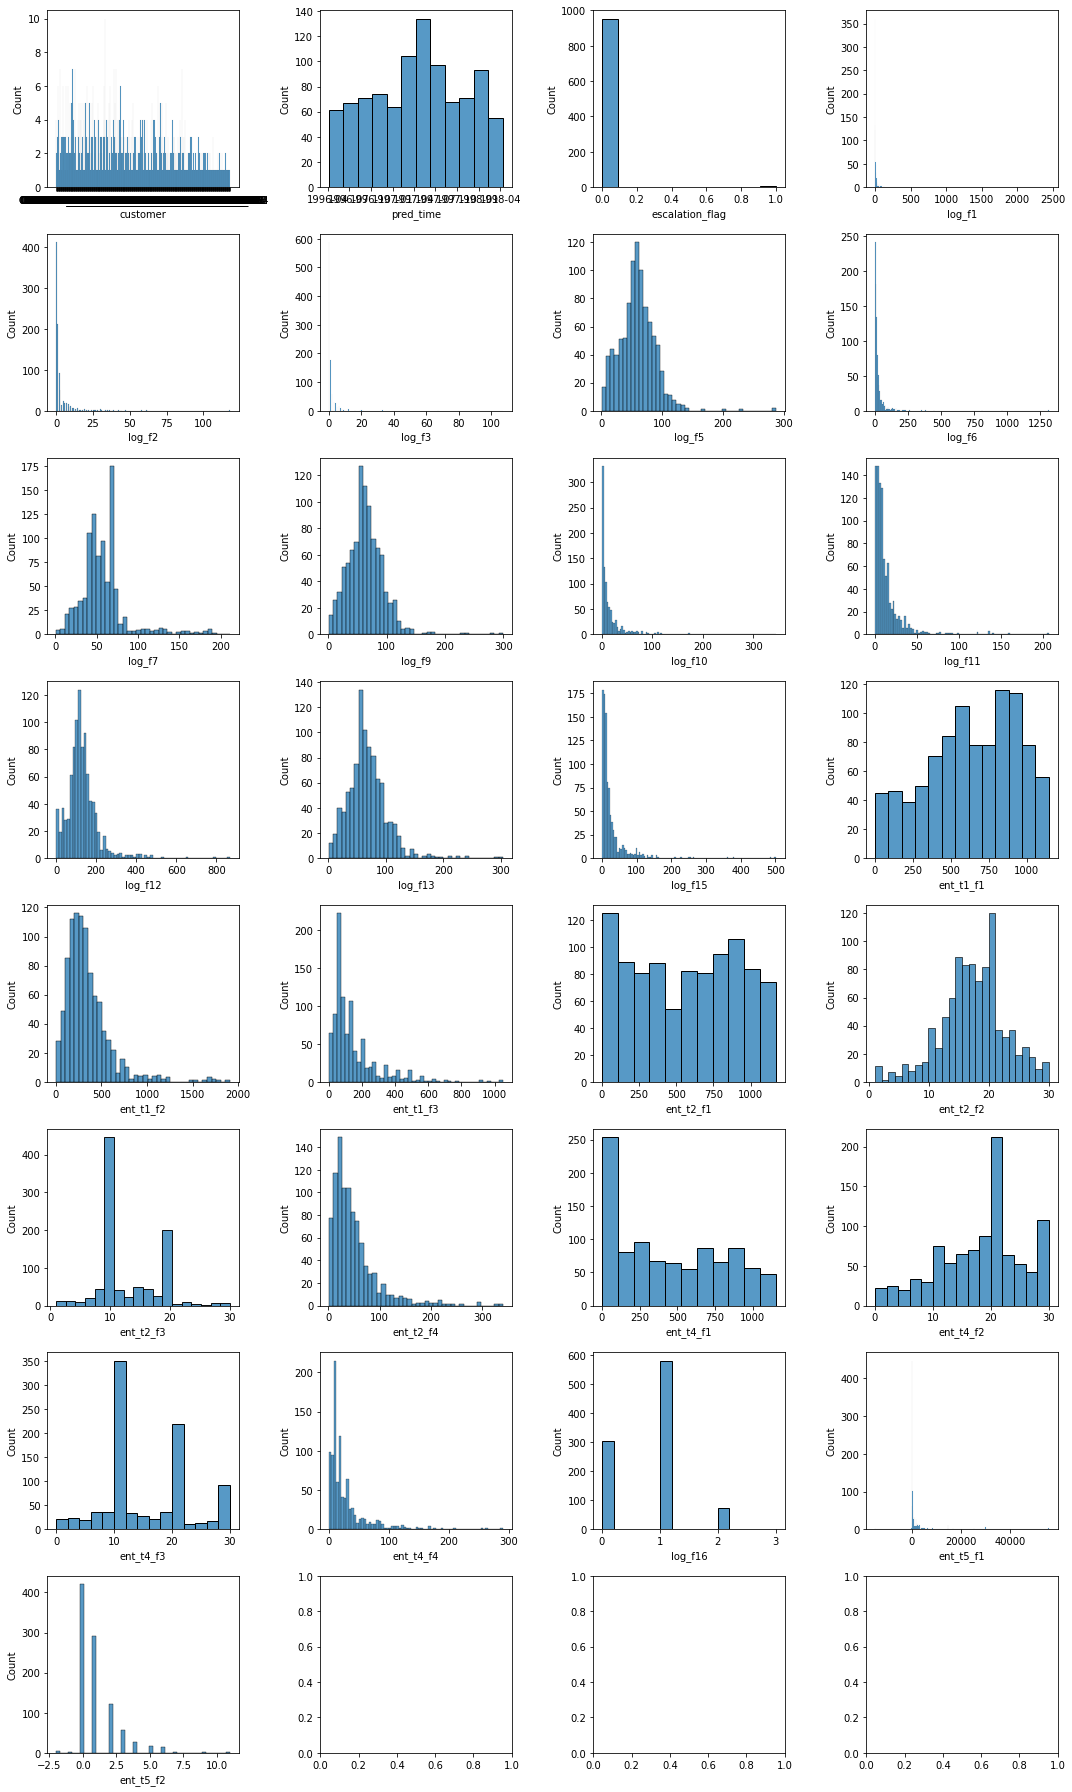

In [22]:
# 레코드 제거 후 독립변수 분포 재확인
# - 0의 비중이 과도하게 높았던 문제가 어느 정도 해결되어 대부분의 변수에서 포아송 분포의 특징이 관찰되며
# - 날짜별 데이터 수도 비교적 균등하게 샘플링됨
# - 다만 고객사별 데이터 빈도수가 대부분 1로 낮아졌음
data = zero_reduce_data.copy()

plot_variable_hist(data)

#### 변수 선택 및 변환

In [23]:
# 분석대상이 될 독립변수 선택
data = zero_reduce_data.copy()

# 1. 변수 유형 구분이 없는 전체 집합
all_columns = list(data.columns)
regressors = [col for col in all_columns if col != target] # 종속변수만 제외

# 2. 더미/명목 변수를 제거한 부분 집합 (연속형)
regressors_cont = [col for col in regressors if col not in (
    'customer', # 고객명
    'pred_time', # 날짜
    'log_f16', # 분포상 categorial 변수로 추정
    'ent_t4_f3', # 연속형 데이터로 보이나 이산형 분포와 유사한 특성을 보임
)]

# 3. 연속형 변수에 시간 인덱스까지 포함
# 서브샘플링할 수 없는 고객 정보는 포함시킬 수 없음
regressors_cont_index = regressors_cont + ['pred_time']

전체 데이터 count: 9,588


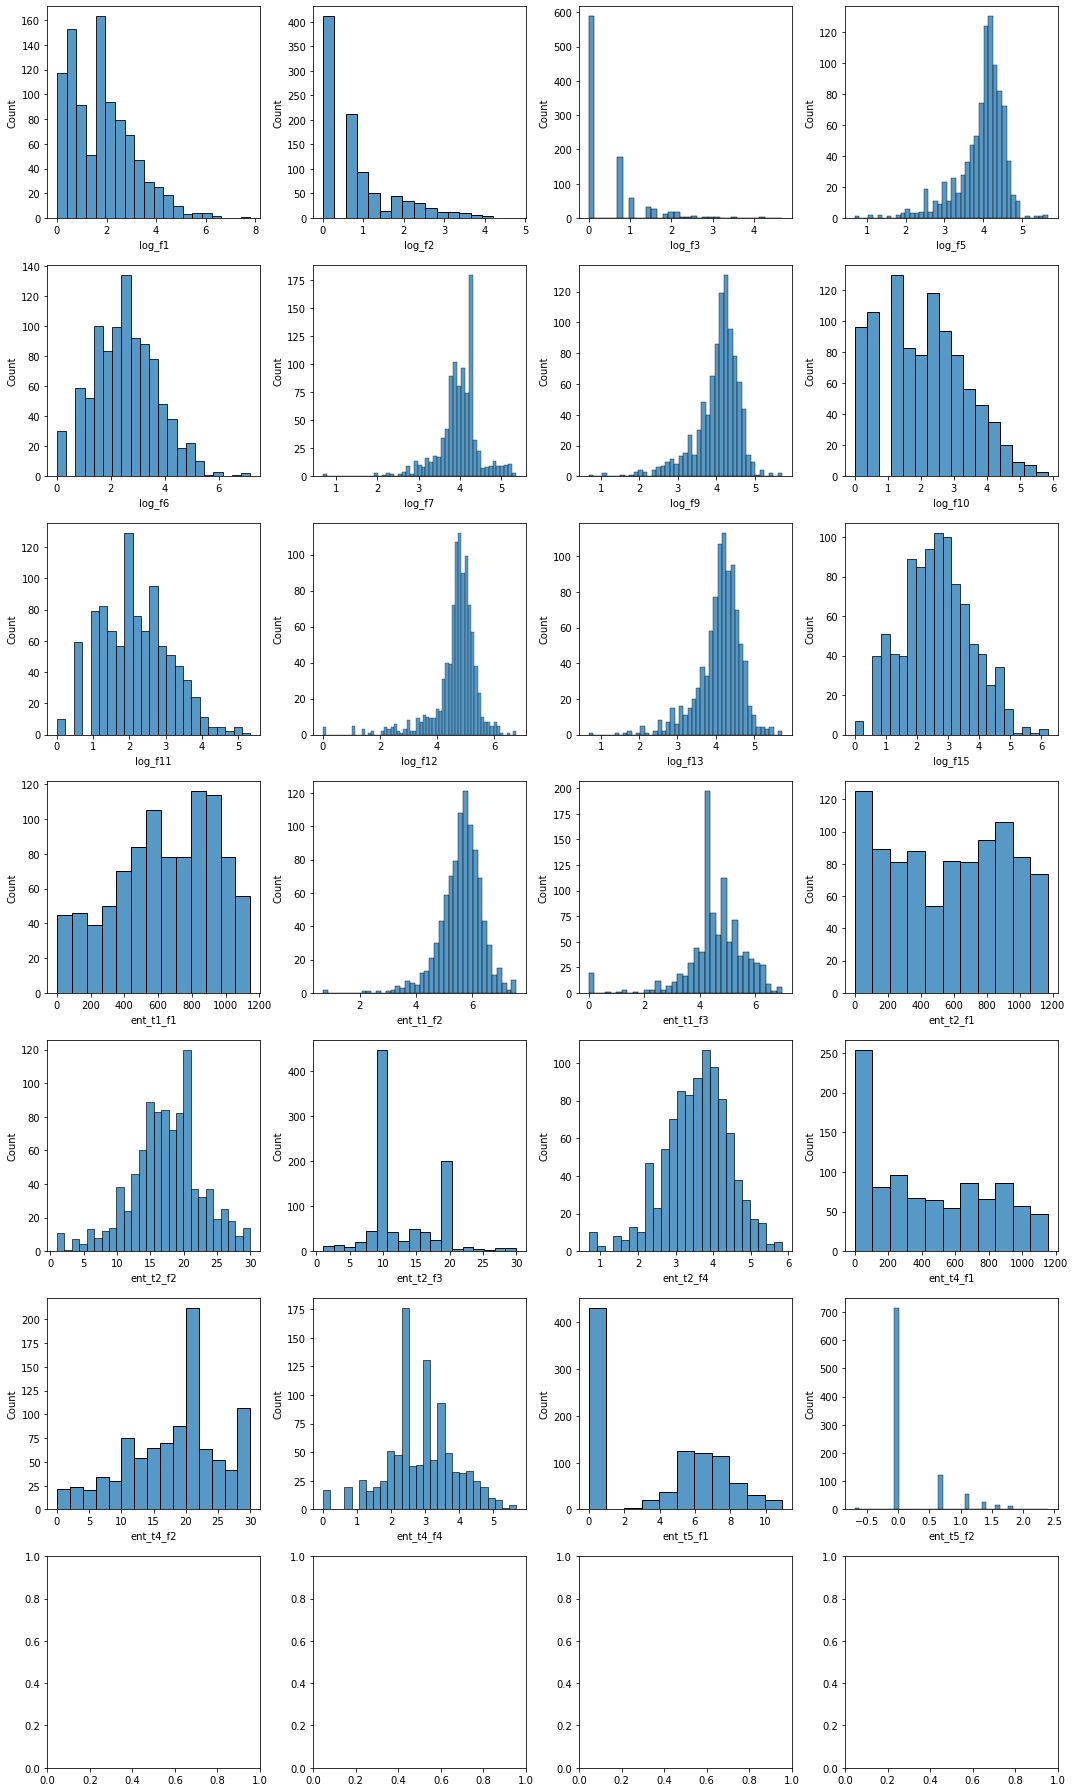

In [24]:
# 회귀분석은 독립변수에 대한 종속변수의 조건부 확률을 구하는 것
# 따라서 개별 독립변수의 분포 형태는 분석에 큰 영향을 미치지 않으나,
# 잠재변수 도출을 위해 차원축소를 시행할 예정이므로 독립변수가 선형성을 갖도록 변환해야 함

# 포아송 데이터에 대한 로그변환으로 정규분포와 유사한 형태가 나오는지 확인
data = zero_reduce_data.copy()

# 0 값을 보존하기 위해 log(x+1) 로그변환
logged_data = data[regressors_cont].apply(np.log1p).fillna(0)
# 단, 이상치로 보기 어려운 숫자의 음수값이 존재하는 ent_t5_f2 컬럼은 별도로 정의한 "대칭 로그"를 사용
logged_data['ent_t5_f2'] = data['ent_t5_f2'].apply(symmetric_log).fillna(0)
# 로그를 취하면 오히려 선형성이 떨어지는 변수는 변환 없이 그대로 사용
logged_data['ent_t1_f1'] = data['ent_t1_f1']
logged_data['ent_t2_f1'] = data['ent_t2_f1']
logged_data['ent_t2_f2'] = data['ent_t2_f2']
logged_data['ent_t2_f3'] = data['ent_t2_f3']
logged_data['ent_t2_f3'] = data['ent_t2_f3']
logged_data['ent_t4_f1'] = data['ent_t4_f1']
logged_data['ent_t4_f2'] = data['ent_t4_f2']

plot_variable_hist(logged_data)

#### 표준화 및 정규성 검정

In [25]:
# 변수(feature) 스케일링
# 차원축소 및 정규분포를 따르도록 전처리할 예정이므로 "표준화" 선택
from sklearn.preprocessing import StandardScaler

data = logged_data.copy()
scaler = StandardScaler()

std_data = scaler.fit_transform(data[regressors_cont])
std_data = pd.DataFrame(std_data, columns=regressors_cont, index=data[regressors_cont].index)

# index를 제외한 명목/종속 변수는 다시 삽입하지 않음
# 추후 별도 모델을 통해 차이만 다시 검정
std_data['pred_time'] = std_data.index.map(var_select_data['pred_time'])
std_data['customer'] = std_data.index.map(var_select_data['customer'])
# std_data['log_f16'] = std_data.index.map(var_select_data['log_f16'])
# std_data['ent_t4_f3'] = std_data.index.map(var_select_data['ent_t4_f3'])
std_data[target] = std_data.index.map(var_select_data[target])

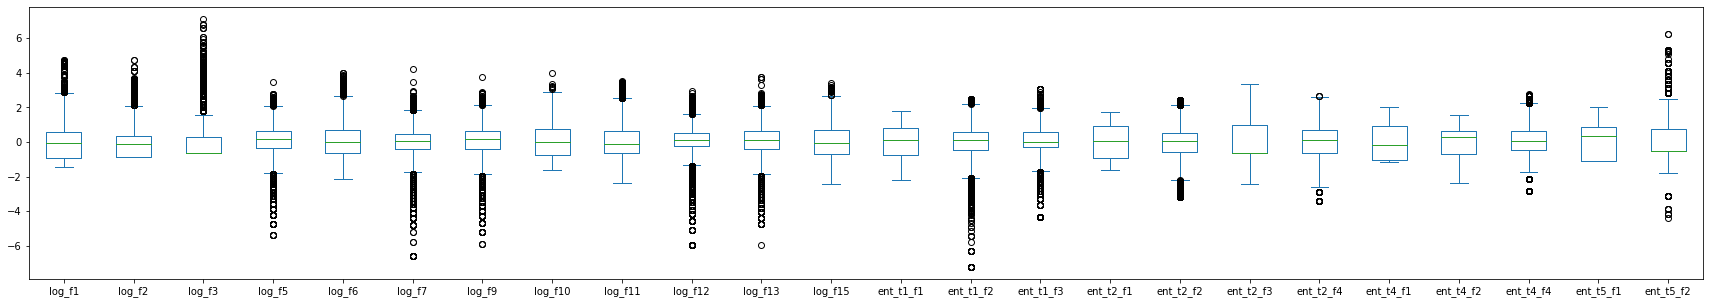

In [26]:
# 이상치 식별
# 단위 스케일링 이후 체크해보면 상당한 수준의 아웃라이어가 존재
# 이상치가 학습에 사용되면 모델이 망가지기 쉬운 부스팅(Boosting) 계열의 머신러닝 모델을 사용한다면 주의가 필요하나
# 로지스틱 기반 이상치 탐지 모델을 만드는 과정이므로 데이터를 제거하지 않고 진행
# 추후 모델 유의성 향상을 위해 필요하다면 cap을 씌우는 방식으로 극단치를 대체할 수 있음

data = std_data.copy()[regressors_cont]
data.plot(kind='box', figsize=(30,5))
plt.show()

변수간 상관관계

- 논문에서는 log... 변수는 장비에서 발생한 머신 로그,
- ent... 변수는 고객사로부터 발생한 데이터 (문의 인입 내용 및 유형)으로 정의하고 있음
- 즉 log 변수는 설비/환경 팩터, ent 변수는 휴먼 팩터로 간주할 수 있음
- 예상했던 것처럼 log..., ent... 변수한 강한 상관관계 존재

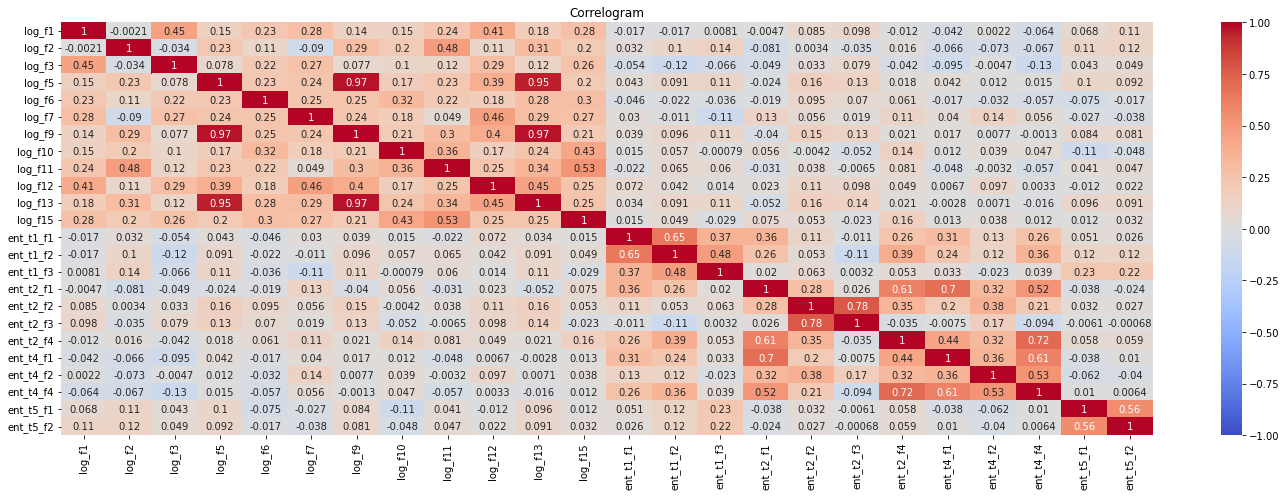

In [27]:
# 필요 이상의 강한 상관관계(>0.9)를 보이는 변수가 눈에 띔
# (log_f5-log_f13, log_f5-log_f9, log_f9-log_f13)

# 선형종속인 독립변수를 사용한 회귀모델의 변수 유의성은 신뢰할 수 없으므로,
# vector space가 겹치는 변수를 제거하거나 차원축소 후 분석해야 함
# 특히 본 데이터셋에서는 0값이 상관관계에 강한 영향을 미칠 가능성 높음

data = std_data.copy()[regressors_cont]

fig, axs = plt.subplots(1, 1, figsize=(20, 7))
sns.heatmap(data.corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=True, ax=axs)
axs.set_title("Correlogram")

plt.tight_layout()
plt.show()

정규성 검정

- 변수가 선형성, 즉 정규성을 가질 때 차원축소가 올바르게 이루어질 수 있음
- Q-Q 플롯에서 강한 비선형성이 관찰되며 0 상태의 데이터가 문제를 일으킨다는 점 확인됨
- 정규분포 검정 결과 모든 변수에 대하여 p-value 0.01 미만으로 해당 변수가 정규분포라는 가설 기각
- 즉, 주어진 데이터는 로그변환을 취하더라도 정규성을 만족하지 않는다는 결론

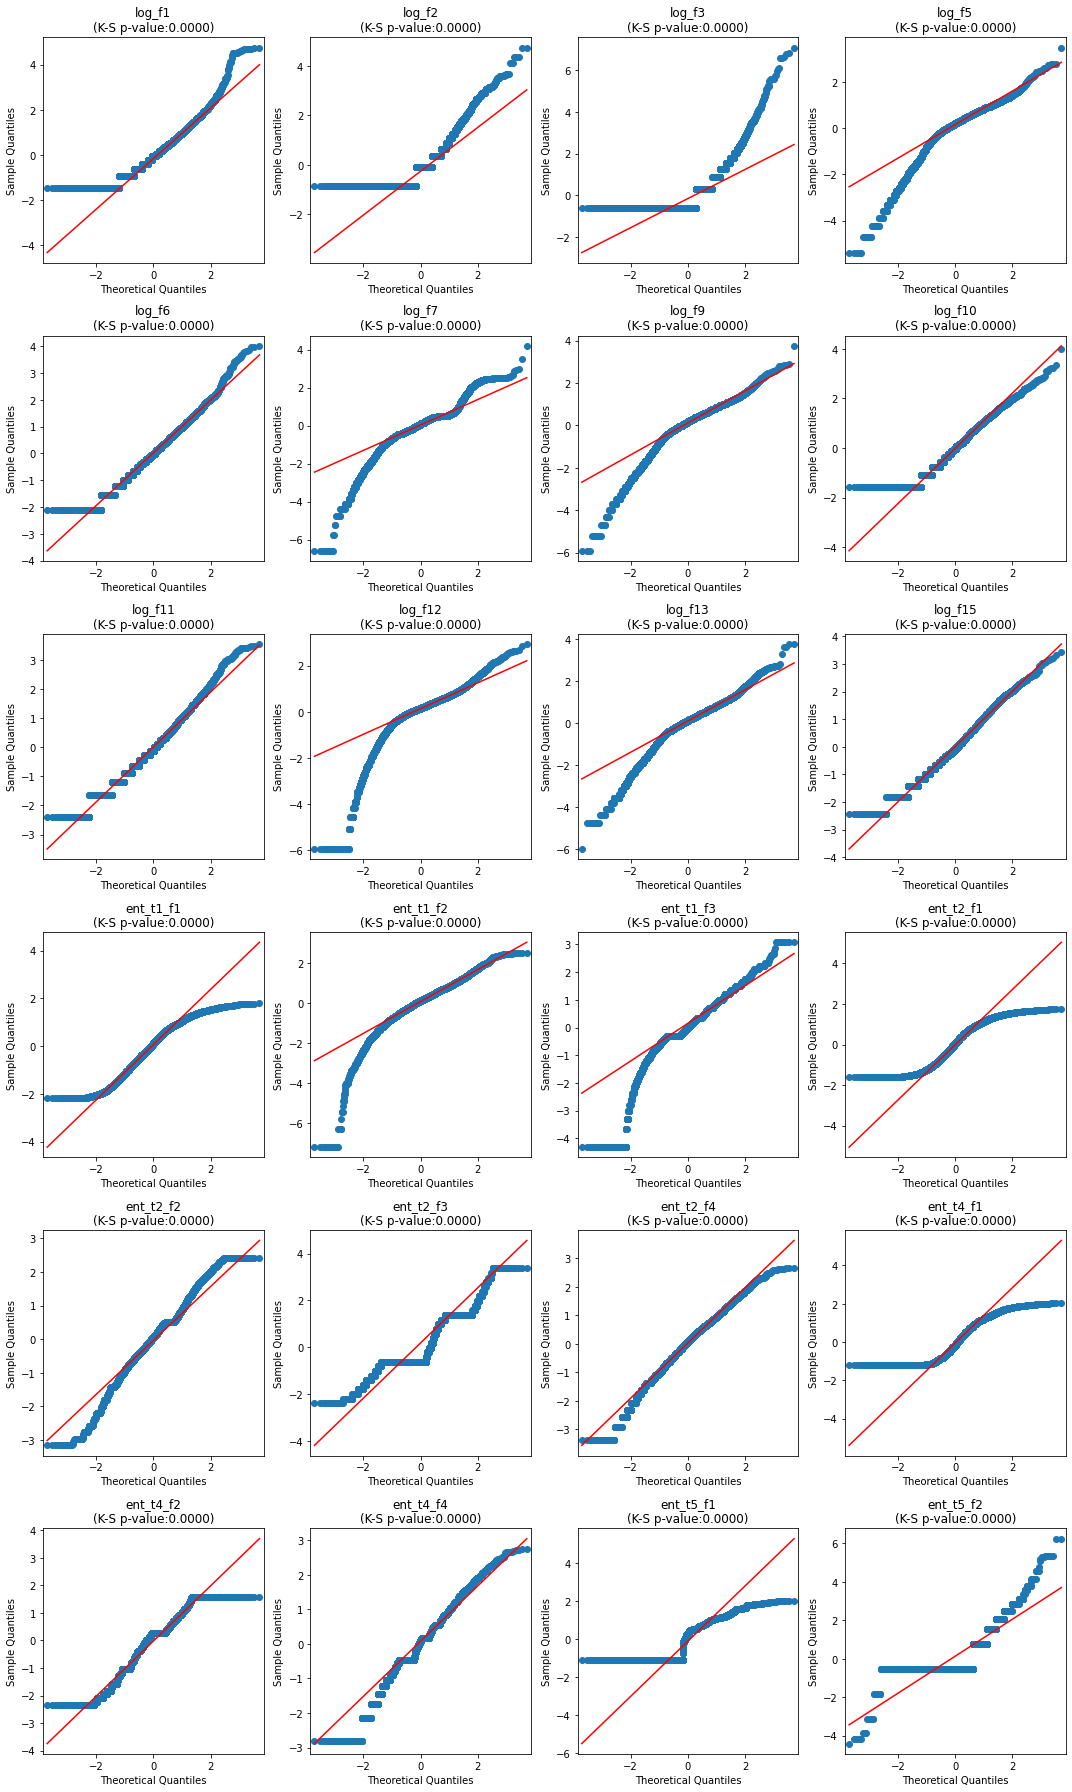

In [28]:
from scipy.stats.distributions import norm
from scipy.stats import kstest

data = std_data.copy()

fig, axes = plt.subplots(
    ncols=4, 
    nrows=int(np.floor(len(regressors_cont)/4)), 
    figsize=(15,25)
)

for idx, col in enumerate(regressors_cont):
    ax = axes.flatten()[idx]

    # Q-Q plot: for eyeball test
    sm.qqplot(
        data=data[col],
        dist=norm,
        loc=0,
        scale=1,
        line='q', # {None, “45”, “s”, “r”, “q”}
        ax=ax,
    )
    # Kolmogorov-Smirnov test
    KStest = kstest(
        rvs=data[col],
        cdf='norm',
        mode='approx',
    )
    title_text = f'{col}'
    title_text += f'\n(K-S p-value:{KStest.pvalue:.4f})'
    ax.set_title(title_text)

plt.tight_layout()
plt.show()

정규성 검정에 실패했으므로 이 데이터를 기반으로 차원축소 기반의 모델을 구축하면 불완전한 결과가 나올 것

생각해볼 수 있는 대안:
1. 비선형성이 강한 변수를 분석에서 제외하거나
2. Box-Cox 변환 등 정규화를 위해 추가적인 데이터 변환을 시도하거나
3. 포아송 분포를 따르는 빈도수 집계(Count)가 아니라, 중심극한정리를 따르는 데이터를 수집하도록 도메인 전문가와 업무 프로세스의 변경을 고민해볼 수 있으며
4. 마지막으로 모델의 예측 범위를 제한시켜 정규분포를 만족시키는 구간과 아닌 구간을 분리하여 분석 대상으로 삼을 수 있음

여기서는 **선형 관계가 유지되는 데이터가 수집되는 구간에서만 모델 예측을 신뢰할 수 있다**는 전제를 두고 모델링을 진행



#### 데이터 구간 분할

Chow test를 이용하면 시계열 데이터에서 특정 시점을 기점으로 데이터에 구조적인 변화(regime change)가 있는지 검정할 수 있다고 알려져 있음
- 데이터 전체에 하나의 full/unconstrained 모델을 적합하는 것과 
- 특정 시점을 기준으로 데이터를 나누고 개별 reduced/constrained 모델을 각각 적합하는 것 중 
- 어느 모델이 데이터를 더 잘 설명하는지 F 검정통계량을 이용하여 검정

다만 주어진 데이터는 이항 형식으로 해당 기법을 활용하기 어려우므로 **논문에서 단위기간으로 설정된 10주** 간격으로 임의 분할


[참고] \\
https://en.wikipedia.org/wiki/Chow_test

In [29]:
# 공통 함수
from datetime import timedelta

# 지정된 기간에 속하는 개별 날짜 반환
def datetime_range(start, end, delta):
    current = start
    if not isinstance(delta, timedelta):
        delta = timedelta(**delta)
    while current < end:
        yield current
        current += delta

from matplotlib.dates import num2date
import pytz

# 기간을 분할하는 수직선 긋기
def add_subperiod_vline(ax=None):
    if not ax: ax = plt.gca()
    for i in range(len(subperiod_points)):
        if num2date(ax.axes.get_xlim()[1]) > pytz.utc.localize(subperiod_points[i]):
            ax.axes.axvline(x=subperiod_points[i], color='firebrick', lw=1, ls='--')

선형성을 기준으로 기간별로 구간을 나눌 수 있는가?

1. 다변수 정규분포 검정
- 10주 간격으로 기간을 분할하여 검정했을 때, 모든 구간에서 H-Z 검정의 p-value < 0.001
- 다변수 정규분포는 어떤 구간에서도 성립을 주장하기 어려움
- 즉, 다변수 정규분포 성립 여부로 구간을 나눌 수 없음
- 다만 실무적으로 다변수 정규분포를 충족하는 데이터는 흔하지 않은 것으로 알려져 있어 특이한 경우는 아님

Henze-Zirkler multivariate normality test
* H0: Test statistic is approximately log-normally distributed
* H1: not H0

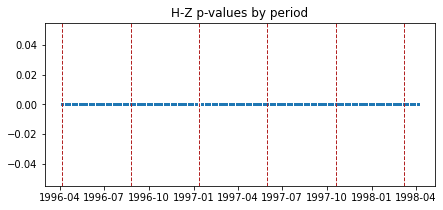

In [30]:
colums_to_fetch = regressors_cont + ['pred_time']
data = std_data[colums_to_fetch].copy()

window_N = 20 # 구간분할 단위 기간

pred_time_min = data['pred_time'].min() # 1996-04-07
pred_time_max = data['pred_time'].max() # 1998-04-12
pred_time_list = datetime_range(pred_time_min, pred_time_max, {'weeks': window_N})

subperiod_points = [] # 기간 시작날짜
for dt in pred_time_list:
    subperiod_points.append(dt)

data_by_period = []
for idx, dt in enumerate(subperiod_points):
    dt_next = subperiod_points[idx+1] if idx+1 < len(subperiod_points) else pred_time_max
    _data = data.query('(pred_time >= @dt) and (pred_time < @dt_next)').copy()

    np_data = _data[regressors_cont].to_numpy()
    # Henze-Zirkler test for Multivariate Normality
    _hz_test = pg.multivariate_normality(np_data, alpha=.1) # 10% 유의수준
    _data['hz_statistic'] = _hz_test.hz
    _data['hz_pval'] = _hz_test.pval
    _data['hz_normal'] = _hz_test.normal
    data_by_period.append(_data)
data = pd.concat(data_by_period, axis=0)

fig = plt.figure(figsize=(7,3))
ax = plt.scatter(data['pred_time'], data['hz_pval'], s=3)
plt.title('H-Z p-values by period')
add_subperiod_vline(ax)

plt.show()

2. 단변수 정규분포 검정


각 기간에서, 개별 변수 단위로 정규분포가 성립하는지를 검정
- 0인 데이터를 제외했을 때 개별 독립변수에서 선형성이 관찰되면 단변수 정규분포가 (제한적으로) 성립한다고 가정
- 개별 레코드에서 0인 컬럼의 비율이 일정 수준 이상 높아지면 선형성이 성립하지 않아 예측 불가능한 데이터로 간주해야 한다는 의미


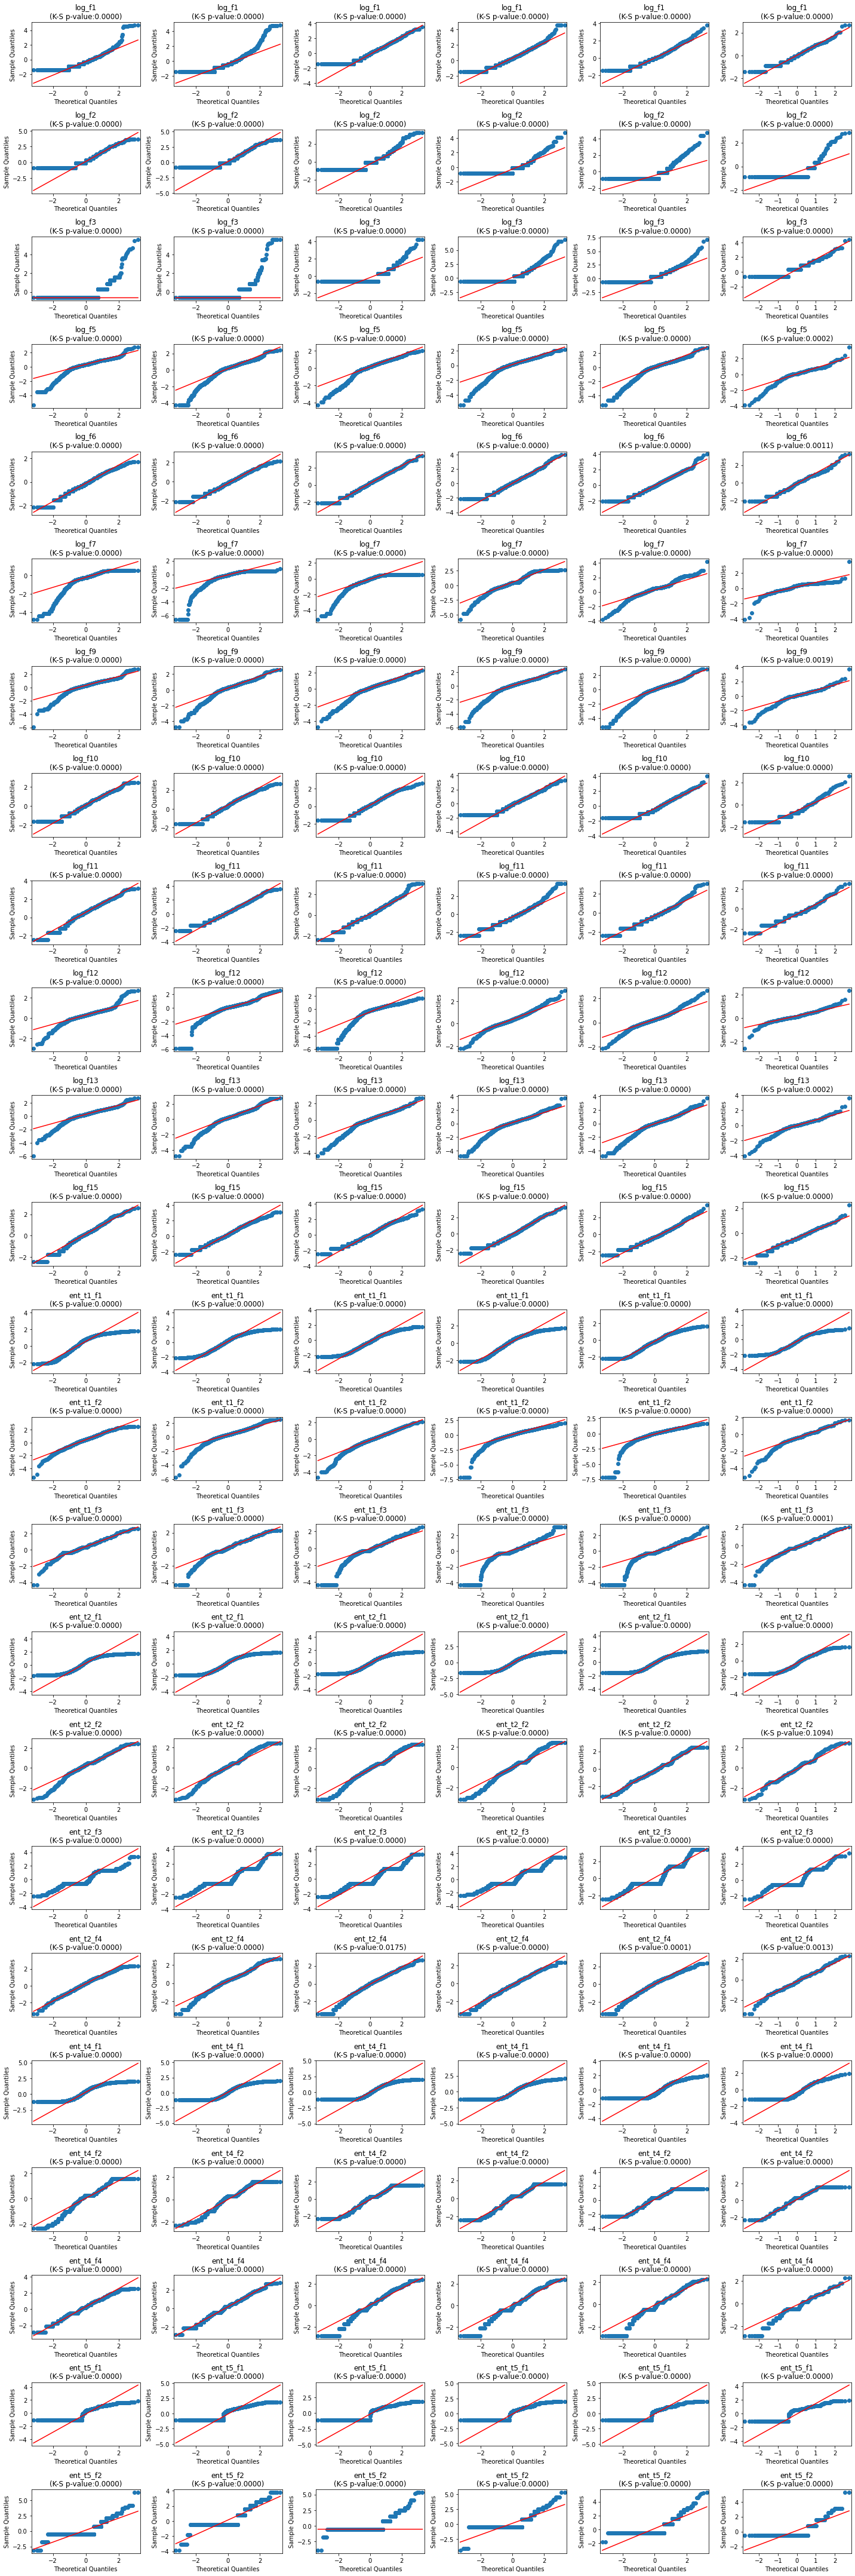

In [31]:
data = std_data.copy()

fig, axes = plt.subplots(
    ncols=len(subperiod_points),
    nrows=len(regressors_cont),
    figsize=(20,60)
)

p_vals = []
for _idx, _data in enumerate(data_by_period):
    p_val = []
    for idx, col in enumerate(regressors_cont):
        ax = axes[idx, _idx]

        # Q-Q plot: for eyeball test
        sm.qqplot(
            data=_data[col],
            dist=norm,
            loc=0,
            scale=1,
            line='q', # {None, “45”, “s”, “r”, “q”}
            ax=ax,
        )
        # Kolmogorov-Smirnov test
        KStest = kstest(
            rvs=_data[col],
            cdf='norm',
            mode='approx',
        )
        title_text = f'{col}'
        title_text += f'\n(K-S p-value:{KStest.pvalue:.4f})'
        ax.set_title(title_text)

        p_val.append(KStest.pvalue)
    p_vals.append(p_val)

plt.tight_layout()
plt.show()

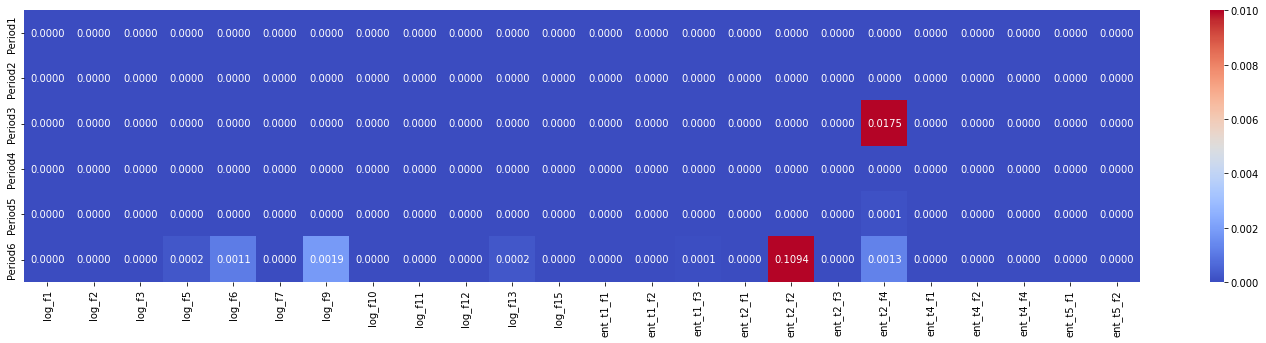

In [32]:
# p-value를 따로 모아서 비교해보면...
# 99% 유의수준에서도 대부분의 Period에서 정규분포 가설이 기각 가능 영역 (p-value < 0.01)
# Period 5,6 정도를 제한적인 선형성이 성립하는 구간으로 임의 가정하고 진행

pvalue_df = pd.DataFrame(p_vals, index=['Period' + str(i+1) for i in range(len(data_by_period))], columns=regressors_cont)

fig, axs = plt.subplots(1, 1, figsize=(25, 5))
sns.heatmap(pvalue_df, cmap='coolwarm', vmin=0, vmax=0.01, annot=True, fmt='.4f', ax=axs)
plt.show()

In [36]:
# 데이터 전처리가 완료된 초기 데이터
data = std_data.copy()

init_data = data.copy()

### 3. 데이터 가공

#### 이상치 확인

In [37]:
# (종속변수) 이상치 분포
# 최초 원본 데이터에서는 전체 레코드의 1.3%에 해당했으나
# 전처리를 거친 뒤 전체 레코드의 0.7%로 줄어들었음

data = init_data.copy()
data[target].value_counts()

0.0000    9522
1.0000      66
Name: escalation_flag, dtype: int64

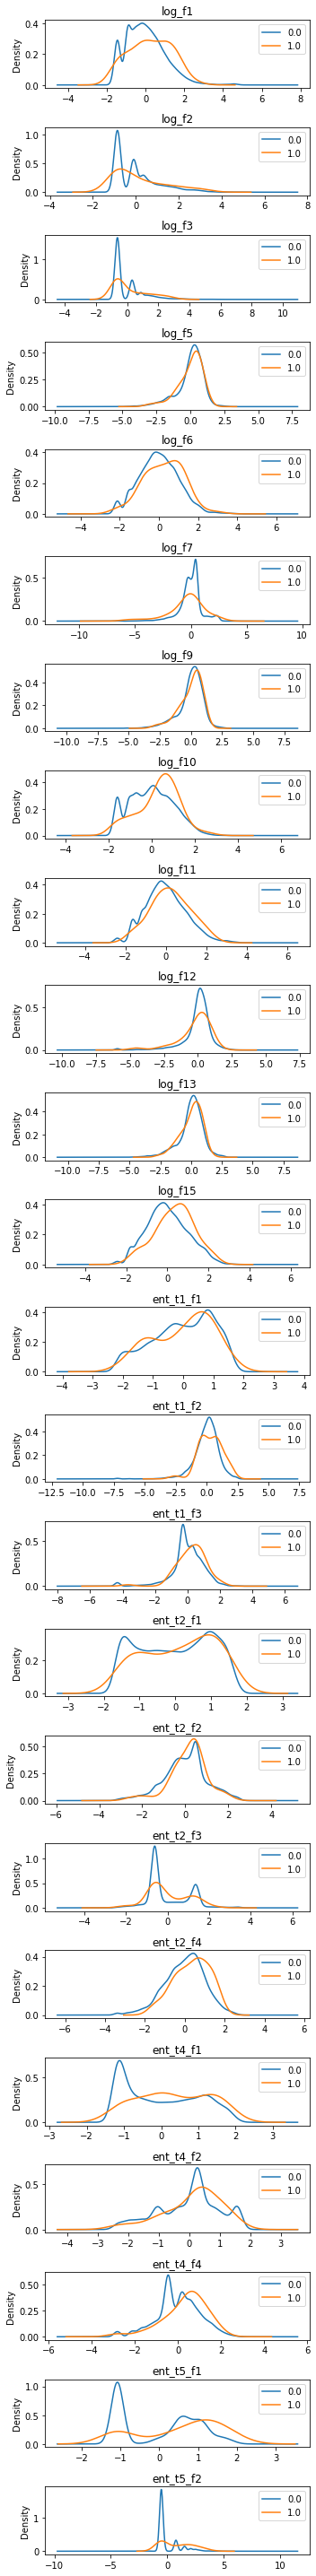

In [38]:
# 정상치-이상치의 개별 독립변수 분포 비교

# 특정한 단일 변수가 이상치 여부에 결정적인 영향을 끼치지는 않는 것으로 보임
# 즉, 변수간의 상관관계를 고려하는 다변수 관점에서 추가적인 분석이 필요해 보임

# 일부 변수에서 정상치는 multi-modal 형태를 갖지만 이상치는 uni-modal 구조를 보임
# 이상치 데이터의 절대적인 수치가 작기 때문에 실제 의미가 있는 부분인지는 주의 필요

data = init_data.copy()

fig, axs = plt.subplots(nrows=len(regressors_cont), ncols=1, figsize=(5, 40))
for idx, col in enumerate(regressors_cont):
    data.groupby([target])[col].plot(kind='kde', legend=True, ax=axs[idx], title=col)

plt.tight_layout()
plt.show()

#### 학습-검증 데이터 분리

In [39]:
from sklearn.model_selection import train_test_split

data = init_data.copy()
X_train_init, X_test_init, y_train_init, y_test_init = train_test_split(
    data[regressors_cont_index], 
    data[target], 
    test_size=0.20, 
    random_state=random_state
)

print("X_train : " + str(X_train_init.shape))
print("y_train : " + str(y_train_init.shape))
print("X_test : " + str(X_test_init.shape))
print("y_test : " + str(y_test_init.shape))

X_train_init

X_train : (7670, 25)
y_train : (7670,)
X_test : (1918, 25)
y_test : (1918,)


,log_f1,log_f2,log_f3,log_f5,log_f6,log_f7,log_f9,log_f10,log_f11,log_f12,...,ent_t2_f1,ent_t2_f2,ent_t2_f3,ent_t2_f4,ent_t4_f1,ent_t4_f2,ent_t4_f4,ent_t5_f1,ent_t5_f2,pred_time
21424,-0.9142,2.8907,0.3136,1.2367,0.3110,0.2185,1.5812,1.6545,1.3635,0.9571,...,-0.9881,-0.2587,-0.2144,-0.1683,-0.6634,-0.5140,-0.7693,1.3943,-0.5184,1996-09-15
104329,0.9486,-0.8562,0.3136,-1.1631,1.1581,2.4994,-1.2644,1.7935,-0.2648,0.7267,...,0.4379,2.1120,2.5745,-0.9445,-0.1853,0.2742,-0.4562,-1.0824,-0.5184,1997-09-21
5757,-1.4527,-0.0999,-0.6306,0.4407,-1.5481,0.1202,0.4933,0.2836,0.3250,-0.6230,...,1.5469,0.9124,1.3792,0.3691,0.8115,0.9311,0.1795,-1.0824,-0.5184,1996-12-15
56480,1.5864,-0.8562,0.3136,-1.4376,0.9257,-0.1301,-1.5357,-1.5889,0.6398,-0.2502,...,1.1423,0.3266,-0.6128,0.5670,1.6101,0.7121,1.2278,-1.0824,-0.5184,1997-04-27
25684,-0.0608,-0.0999,-0.6306,-1.6785,0.0588,-0.2479,-1.2644,0.7053,1.5572,0.0813,...,-0.5297,-0.3130,-0.6128,0.4388,-1.1768,0.2742,-0.4562,-1.0824,-0.5184,1996-10-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20565,-0.5992,-0.0999,-0.6306,0.4644,-0.9757,0.1863,0.6271,0.1462,-0.2648,0.3437,...,0.0361,-1.0838,-0.6128,0.8529,-1.1768,1.5879,0.1795,-1.0824,-0.5184,1997-12-07
80313,1.4871,-0.8562,-0.6306,0.8026,-0.3061,0.4871,0.7514,0.6299,-0.2648,0.6186,...,-0.2751,0.5025,1.3792,-0.5186,-0.2397,0.2742,-0.4562,0.4807,-0.5184,1997-04-20
75214,-1.4527,-0.8562,-0.6306,0.1268,0.9461,-0.3304,0.0175,-0.5442,-1.1919,-1.6810,...,-0.8042,0.5208,-0.6128,0.1881,-0.3945,0.2742,0.5302,-0.1581,-0.5184,1997-01-05
27741,0.0590,-0.0999,1.5618,-2.9064,-0.5136,-0.2078,-1.7708,-1.0666,0.1255,-0.6043,...,-0.4137,-1.2102,-0.6128,0.1599,-1.1768,0.2742,-0.4562,-1.0824,-0.5184,1997-11-09


#### 서브샘플링

이상치 학습 데이터 추가

- 이상치 데이터의 비중이 너무 작아, 모델이 데이터의 의미를 제대로 학습하기 어려운 상황
- 만약 추후에라도 충분한 데이터가 누적되어 이상치가 따르는 분포함수의 주요 moment를 알고 있거나 추정할 수 있다면 시뮬레이션을 통해 생성 가능
- 하지만 현재로서는 정상치 데이터를 줄이거나, 이상치 데이터를 늘리는 서브샘플링(sub-sampling) 접근 필요
- 학습(training) 데이터에만 적용해야 올바른 검증 가능

오버샘플링 vs. 언더샘플링

- 바쁘게 돌아가는 물류현장에서, 그것도 실시간으로 수집할 수 있는 정보는 매우 제한적임을 고려하면 개별 데이터의 가치 높음
- 이를 감안하면 언더샘플링은 정상치로부터 의미있는 정보량을 제거할 우려가 있다는 점에서 적절하지 않음
- 또한 아래 분석 과정 중에서 정상치 데이터가 multi-modal 분포를 보이나 이상치 데이터는 uni-modal 분포를 보임을 확인
- 결론적으로 이상치 데이터의 오버샘플링이 상대적으로 더 합리적인 것으로 판단


In [40]:
# SMOTE(Synthetic minority oversampling technique)
# kNN 알고리즘을 활용한 오버샘플링 기법을 중심이지만 다수 클래스에 대한 언더샘플링도 동시에 진행하는 hybrid 서브샘플링
# precision은 낮아지지만 recall은 높아질 것으로 예상

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

smote = SMOTE(
    sampling_strategy="all",
    random_state=random_state,
)

# 실수 형태가 아닌 데이터 보존되지 않음
le = LabelEncoder()

# 오버샘플링 이후 구간을 나누기 위해 pred_time 복원
_data = X_train_init.copy()
_data['pred_time'] = le.fit_transform(_data['pred_time'])
X_train_over, y_train_over = smote.fit_resample(_data, y_train_init)
X_train_over['pred_time'] = le.inverse_transform(X_train_over['pred_time'])

X_train_over

,log_f1,log_f2,log_f3,log_f5,log_f6,log_f7,log_f9,log_f10,log_f11,log_f12,...,ent_t2_f1,ent_t2_f2,ent_t2_f3,ent_t2_f4,ent_t4_f1,ent_t4_f2,ent_t4_f4,ent_t5_f1,ent_t5_f2,pred_time
0,-0.9142,2.8907,0.3136,1.2367,0.3110,0.2185,1.5812,1.6545,1.3635,0.9571,...,-0.9881,-0.2587,-0.2144,-0.1683,-0.6634,-0.5140,-0.7693,1.3943,-0.5184,1996-09-15
1,0.9486,-0.8562,0.3136,-1.1631,1.1581,2.4994,-1.2644,1.7935,-0.2648,0.7267,...,0.4379,2.1120,2.5745,-0.9445,-0.1853,0.2742,-0.4562,-1.0824,-0.5184,1997-09-21
2,-1.4527,-0.0999,-0.6306,0.4407,-1.5481,0.1202,0.4933,0.2836,0.3250,-0.6230,...,1.5469,0.9124,1.3792,0.3691,0.8115,0.9311,0.1795,-1.0824,-0.5184,1996-12-15
3,1.5864,-0.8562,0.3136,-1.4376,0.9257,-0.1301,-1.5357,-1.5889,0.6398,-0.2502,...,1.1423,0.3266,-0.6128,0.5670,1.6101,0.7121,1.2278,-1.0824,-0.5184,1997-04-27
4,-0.0608,-0.0999,-0.6306,-1.6785,0.0588,-0.2479,-1.2644,0.7053,1.5572,0.0813,...,-0.5297,-0.3130,-0.6128,0.4388,-1.1768,0.2742,-0.4562,-1.0824,-0.5184,1996-10-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15223,0.7038,-0.3249,-0.6306,-1.0434,-0.7059,-4.2946,-1.2572,0.0536,-0.0167,-1.2212,...,-0.9729,0.1581,0.2319,-0.4174,-1.1663,-2.2751,-2.4923,1.1623,2.4277,1996-09-08
15224,1.3986,-0.8562,2.3625,0.6285,0.9359,2.2595,0.5895,-0.7610,-0.6329,0.9192,...,0.9808,-0.3559,-0.6128,0.8438,0.2048,1.2122,0.9182,-1.0824,-0.5184,1997-10-12
15225,-0.7636,0.1117,-0.6306,0.0681,0.1640,-1.8256,0.0700,0.8876,0.3821,-0.2596,...,-1.5341,-2.3900,-2.0073,-0.7437,-0.8316,-1.5010,-0.4859,-0.6675,0.0642,1996-10-20
15226,1.4219,-0.8562,2.3625,0.6622,1.0742,2.3435,0.6157,-0.7610,-0.6329,0.9710,...,0.9545,-0.3235,-0.6128,0.8037,0.1279,1.2160,0.8714,-1.0824,-0.5184,1997-10-12


In [41]:
# 서브샘플링까지 완료된 학습 데이터를
# 위에서 구분했던 구간(sub-period)별로 다시 쪼개기

X_train_by_period = []
y_train_by_period = []
X_test_by_period = []
y_test_by_period = []

for idx, dt in enumerate(subperiod_points):
    dt_next = subperiod_points[idx+1] if idx+1 < len(subperiod_points) else pred_time_max

    _data_train_x = X_train_over.query('(pred_time >= @dt) and (pred_time < @dt_next)').copy()
    _data_train_y = y_train_over[_data_train_x.index]
    _data_test_x = X_test_init.query('(pred_time >= @dt) and (pred_time < @dt_next)').copy()
    _data_test_y = y_test_init[_data_test_x.index]

    # 분석에 영향을 미치지 않는다고 가정한 pred_time 미포함
    columns_except_date = [col for col in X_train_over.columns if col != 'pred_time']

    X_train_by_period.append(_data_train_x[columns_except_date])
    y_train_by_period.append(_data_train_y)
    X_test_by_period.append(_data_test_x[columns_except_date])
    y_test_by_period.append(_data_test_y)

In [42]:
# 구간을 나눔으로써 분석에 영향을 미치지 않는다고 가정한 pred_time 제거
X_train_over.drop(columns=['pred_time'], inplace=True)
X_test_init.drop(columns=['pred_time'], inplace=True)

### 4. 독립변수 선택

#### 변수 선택 (1): 관찰가능 변수

- 표면적으로 관찰 가능한 변수는 이해가 직관적이라는 장점이 있지만
- 데이터의 규모가 크고 복잡성이 높아질수록 그 안에 잠재되어 있는 구조적인 요인과는 괴리될 가능성
- 관측가능한 변수에 집착하게 되면 인과관계가 아닌 상관관계를 발견하게 될 가능성
- 다중공선성이 존재하는 상태에서 회귀분석에 사용할 경우 회귀계수의 유의성을 낮추게 됨

관측가능 변수로 회귀모형을 구성 시

- 전진선택법, 후진소거법 등의 step-wise regression을 통해 변수를 선택하기도 하나, 
- 변수 간의 상관관계에 따라 그 결과가 달라질 수 있는 강건하지 않은 방법

- 또한 아직 알려지지 않았거나 측정 가능하지 않은 변수가 존재할 가능성을 배제할 수 없음
- 이 경우 omitted variable bias가 발생하여 회귀분석의 성립조건 중 하나인 독립변수와 노이즈간의 독립성 전제가 꺠지게 됨

결론적으로 
- 변수선택은 기계적으로 접근할 것이 아니라, 해당 도메인 전문가와의 긴밀한 협의가 필수적이며
- PCA나 요인 분석(Factor analysis)을 통해 잠재 변수(latent factor)로 추상화하는 것이 문제의 본질에 가까운 접근

In [43]:
# 일반 로지스틱 회귀분석은 독립변수의 선형성을 요구하지 않음
# 선형성 충족 여부와 무관하게 모든 변수 선택

regressors_observed = regressors_cont.copy()
X_train_observed = X_train_over[regressors_observed].copy()

#### 변수 선택 (2): PCA 잠재변수

주성분분석(Principal Compoenent Analysis)
- 관찰된 데이터에서 가장 큰 분산을 잡아내는 서로 독립된 축을 찾아냄
* 독립변수의 2차 모먼트인 분산을 분해하여 주된 성분으로 재구성하는 것
* 기존 변수들의 선형 변환이므로 1차식으로 표현 가능
* 정규성을 전제로 하며 3차 이상의 모먼트, 즉 측도나 왜도 등은 감안하지 않음

In [44]:
from sklearn.decomposition import PCA

data = X_train_over[regressors_cont].copy()

pc_names = [f'PC{i+1}' for i in range(len(regressors_cont))]

pca = PCA(
    n_components=None,
    svd_solver='auto', # {‘auto’, ‘full’, ‘arpack’, ‘randomized’}
    random_state=random_state,
).fit(data)

pca_score = pd.DataFrame(
    pca.transform(data), 
    columns=pc_names,
)
pca_score.index -= 1 # pca는 one-based index

# Score matrix: converts to one-based index
pca_score.index += 1
pca_score

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
0,-1.4553,2.8877,-1.5276,-2.1697,-0.3506,0.2231,0.7074,-0.7881,1.0895,0.2715,...,-1.0471,-1.6739,0.4965,0.6198,0.7582,-0.6508,-0.2748,-0.1365,-0.0291,0.0445
1,-0.4178,1.1395,2.9213,1.4251,1.0787,2.8096,-2.5166,1.5304,0.9758,-0.6164,...,0.1573,-0.2762,-0.2602,-0.3376,-0.3289,0.1714,0.4306,0.5120,0.4071,-0.1689
2,0.4564,-1.5158,1.3874,-2.1949,0.7164,1.3500,-0.0053,-0.7793,0.1467,0.4244,...,-0.1354,-0.0874,-1.5521,0.1229,0.0789,-0.3514,0.2817,-0.2006,-0.0408,0.0124
3,0.6027,-2.4719,1.7726,1.5842,-1.4967,0.1118,-1.4853,-0.7523,-0.5137,-0.8191,...,1.0433,1.5235,0.1795,0.6452,-0.8902,-0.0030,-0.2349,0.4178,-0.2196,0.0210
4,1.7448,0.9123,0.3337,0.3356,-2.4084,0.8815,-0.7744,0.3224,0.6906,-0.0558,...,0.1483,0.3374,-1.0651,0.8983,0.1349,0.0708,-0.2209,-0.0373,0.1163,0.1622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15223,4.4098,1.3749,-4.0209,1.6840,0.6718,0.7711,-0.2891,0.5595,-2.3581,-0.3705,...,-0.1113,0.2657,-0.2174,-0.3441,0.4235,0.0543,-0.4714,-0.1751,-0.0590,-0.0661
15224,-2.5943,-0.2601,3.1752,1.1807,-0.1312,-1.6274,-0.2887,-0.7534,0.0392,0.1589,...,0.2645,-0.1381,-0.5594,-0.4913,0.2682,-0.3140,0.1658,-0.0981,0.0403,0.0241
15225,2.0934,2.2332,-1.3583,-1.4412,-2.0662,-1.9306,-0.1223,0.7354,-0.6011,-0.4832,...,-0.3618,0.1284,-0.3040,-0.0219,-0.2364,0.4761,0.0046,-0.1074,0.0079,-0.0957
15226,-2.6835,-0.1338,3.2182,1.1924,-0.0919,-1.6296,-0.3236,-0.6851,0.0608,0.1580,...,0.2690,-0.0969,-0.5259,-0.4957,0.3160,-0.2703,0.1575,-0.0710,0.0308,0.0233


PCA Loading matrix
* 데이터의 추상화된 구조인 주성분에 대한 특정 변수의 기여(관계)를 표현
* 특정 변수가 특정 주성분에 얼마나 영향을 미치는지 파악할 수 있음

* 위에서 언급한 것과 같이 선형변환이므로 다음과 같이 표현할 수 있음
$$PC_1 = 0.36 * V2 + 0.34 * V3 + 0.3 * V4 + \cdots $$
* 선형대수로 나타낼 경우:
$$PC_1 = [0.36, 0.34, 0.3, \cdots] [V2, V3, V4, \cdots]^T$$

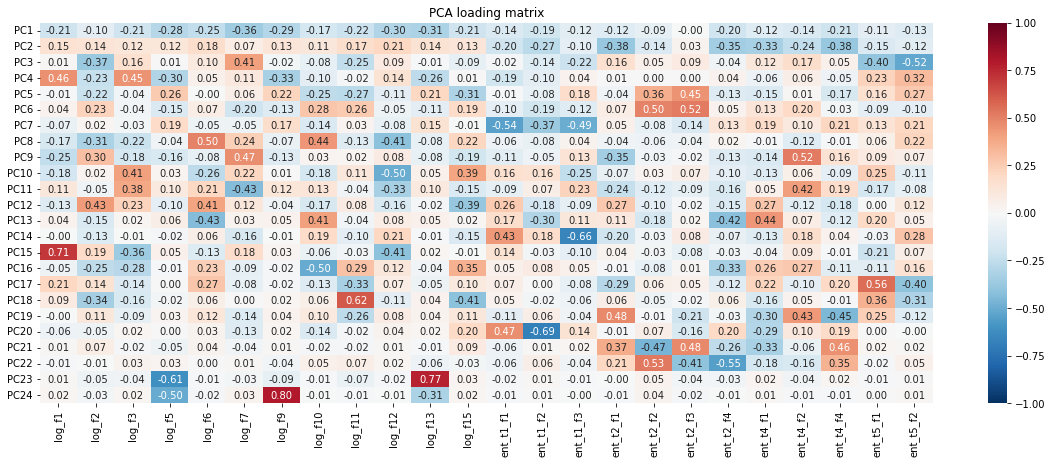

In [45]:
pca_loading = pd.DataFrame(pca.components_, index=pca_score.columns, columns=regressors_cont)

fig = plt.figure(figsize=(20,7))
sns.heatmap(pca_loading, cmap='RdBu_r', annot=True, vmin=-1, vmax=1, ax=plt.gca(), fmt='.2f')
plt.title('PCA loading matrix')
plt.show()

- 비슷한 선형관계를 갖는 변수들은 대체로 비슷한 움직임을 갖는, 비슷한 유형의 변수라는 점을 알 수 있음
- PC1과 달리 PC2에서는 log... 변수와 ent... 변수간의 영향 차이가 두드러짐
- 대다수 주성분에 대해 log_f9 의 영향이 굉장히 강한 것을 확인할 수 있음

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  app.launch_new_instance()


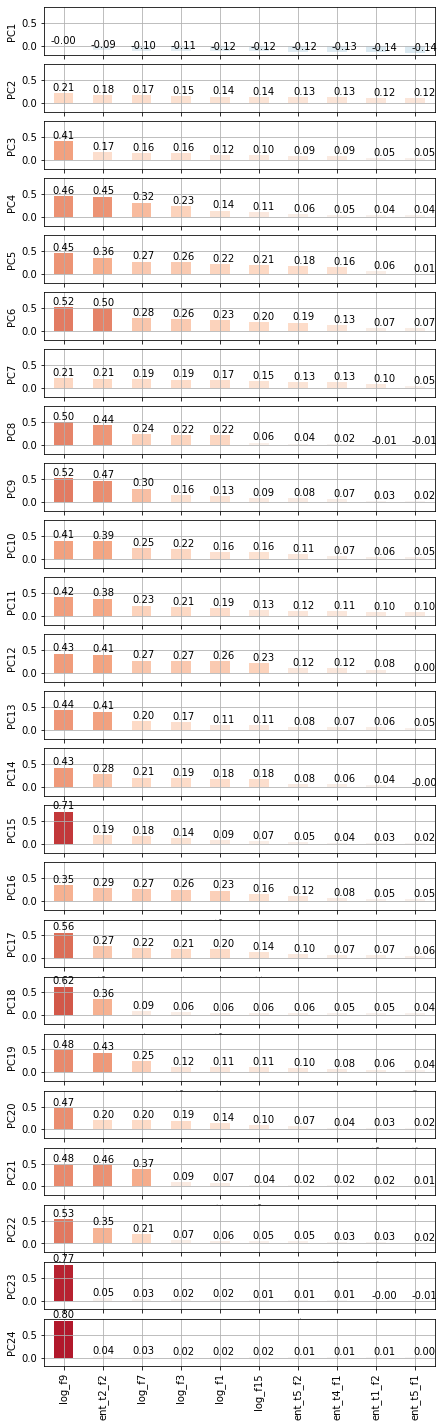

In [46]:
# https://towardsdatascience.com/stock-market-analytics-with-pca-d1c2318e3f0e
from matplotlib import colors

fig, axs = plt.subplots(nrows=len(pca_loading.index), figsize=(7,25), sharey=True)
my_cmap = plt.get_cmap('RdBu_r')
my_norm = colors.Normalize(vmin=-1, vmax=1)

for i in range(len(pca_loading.index)):

    data = pca_loading.T[pca_loading.index[i]].nlargest(10)
    bars = data.plot.bar(ax=axs[i], grid=True, color=my_cmap(my_norm(data)))
    for bar in bars.containers[0]:
        axs[i].annotate(
            f'{bar.get_height():.2f}',
            xy=(bar.get_x()+bar.get_width()/2, bar.get_height()), 
            textcoords="offset points", ha='center', va='bottom'
        )
    axs[i].set_ylabel(f'{pca_loading.index[i]}')

plt.show()

주성분과 차원축소

* PCA는 각 주성분을 고유값, 즉 데이터 분산에 대한 기여도의 내림차순으로 정렬함
* 이중 N개의 주성분만을 취하더라도 데이터 분산의 일정 부분을 설명할 수 있음
* 일부 분산의 설명을 포기(정보의 손실)하는 대가로 상당한 계산비용 절감 효과를 거둘 수 있음
* 낮은 주성분이 보이는 분산은 상대적으로 작은 크기이며, 특정 변수에서만 보이는 노이즈일 가능성이 높음
* 이러한 관점에서 PCA를 일종의 정규화(regularization), 분산 감쇠 기법으로 볼 수도 있음

주성분 수의 선택 (컷오프)

* 로딩 매트릭스를 확인해보면, PC6~7 수준까지는 특정 변수들이 그룹을 형성하다가 그 이후로는 개별적으로 움직이는 것을 볼 수 있음
* 즉, PC6 정도까지는 변수들의 그룹으로 설명되는 어떠한 요인을 대표하고 있다는 것

* 또는 아래와 같이 Scree plot을 그려보고 설명가능한 분산의 한계 증가량이 감소하는 시점에서 선택할 수도 있음

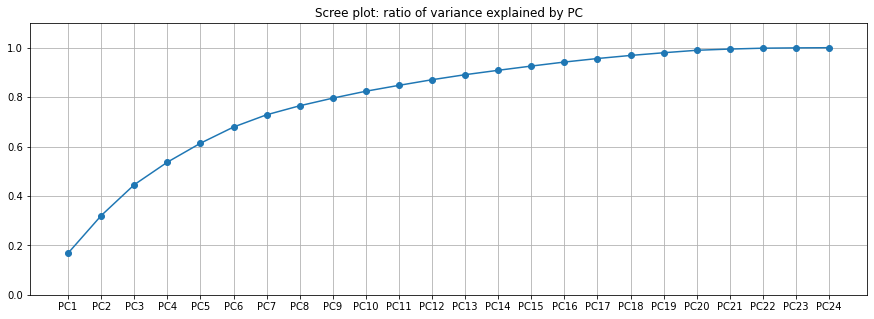

In [47]:
# (cumulative) scree plot

fig = plt.figure(figsize=(15,5))
plt.plot(pca_score.columns, pca.explained_variance_ratio_.cumsum(), '-o')
plt.title('Scree plot: ratio of variance explained by PC')
plt.grid(True)
plt.ylim(0,1.1)
plt.show()

데이터 전체 분산의 70% 가까이를 설명하는 PC6, 즉 주성분 6개를 선택하여 설명변수로 취급

In [48]:
selected_PC_num = 6

regressors_pca = pc_names[:selected_PC_num]
X_train_pca = pca_score.iloc[:, :selected_PC_num]

#### 변수 선택 (3): 요인 잠재변수

PCA 대비 요인분석 강점
* PCA는 선형변환인 반면 요인분석은 비선형 관계로 정의될 수 있음
* 요인분석도 PCA와 마찬가지로 선형성이 성립하지 않는 데이터에서 설명력이 제한되지만
* 비선형 관계를 이용해 일부라도 설명가능하므로 PCA 대비 강점을 가짐
* 또한 각 요인들이 주성분과 달리 독립적(orthogonal)이지 않고 크고 작은 상관관계를 가질 수 있다는 점도 차이점
* (이론과 달리 현실에 존재하는) 요인간의 공분산을 고려함으로써 실제 데이터에 숨겨져 있는 구조를 발견할 수 있는 가능성 높아짐
* 요인분석을 바탕으로 한 로지스틱 회귀분석의 복잡한 네트워크를 구성한 것이 뉴럴 네트워크

요인 분석을 사용하기 위한 전제 조건 검정

1. Henze-Zirkler 다변수 정규성 검정
* H0: Test statistic is approximately log-normally distributed
* H1: not H0

2. Bartlett 구형성 검정
* 변수그룹 간의 이분산성 확인

3. Kaiser-Meyer-Olkin(KMO) test
* 독립변수 분산간의 비율 확인
* 카이스퀘어 검정과 유사한 역할
* 70 이상이 나오면 어느 정도 요인분석이 성립될 수 있다는 것이 관행적 해석

결론적으로 다변수 정규정 검정을 통과하지 못했으므로 **주어진 데이터에서는 요인분석의 설명력이 제한적일 것**임을 추정할 수 있음

In [49]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

data = X_train_over[regressors_cont].copy()

# HZ normality test
print('H-Z normality: ', pg.multivariate_normality(data, alpha=.05))

# Bartlett's sphericity test
chi_square_value, p_value = calculate_bartlett_sphericity(data)
print("Bartlett's sphericity: ", chi_square_value, p_value)

# KMO test for suitability of factor analysis
kmo_all, kmo_model = calculate_kmo(data)
print('KMO test: ', kmo_model)

H-Z normality:  HZResults(hz=28.234459481413076, pval=0.0, normal=False)
Bartlett's sphericity:  250629.93687630392 0.0
KMO test:  0.7084100575279537


/usr/local/lib/python3.7/dist-packages/factor_analyzer/utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


* 요인 분석은 요인의 결정에 있어 분석자의 임의적 판단이 강하게 개입됨
* 휴먼에러에 대한 이론적 접근 및 기타 도메인 지식을 고려하면, 크게 2가지 유형의 변수(feature)를 생각해볼 수 있음
    - 인간(작업자) 변수
    - 환경 변수

* PCA로 추정된 요인의 수가 6개이므로, 각 요인들을 보다 구체화시킬 수 있음
* 예를 들어, 인간 변수를 다음과 같이 세분화시켜볼 수 있음
    - 인지능력 변수
    - 판단능력 변수
    - 신체능력 변수

* 요인분석은 PCA와 달리 회전을 통해 인자의 해석을 용이하게 할 수 있음
* 주어진 문제에서 인간 변수, 환경변수는 요인간의 상관관계가 상당히 크게 나타날 것으로 추정됨
* 따라서 요인 간의 상관관계를 폭넓게 허용하는 Promax 선택

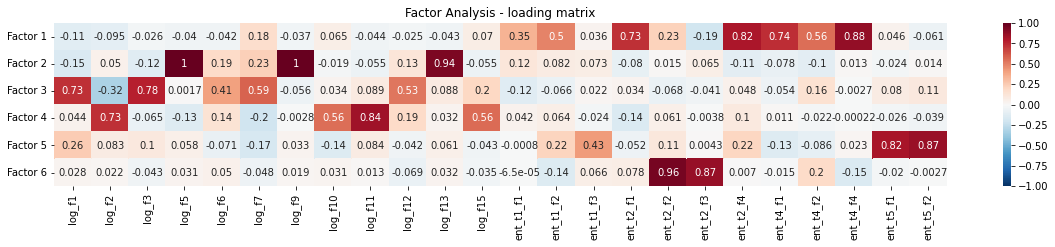

In [50]:
factor_names = [f'Factor {i+1}' for i in range(len(regressors_cont))]

fa = FactorAnalyzer(
    n_factors=selected_PC_num, # PCA에서 찾아낸 수치
    rotation='promax', # None / varimax (orthogonal rotation) / promax (oblique rotation) / oblimin (oblique rotation) / oblimax (orthogonal rotation) / quartimin (oblique rotation) / quartimax (orthogonal rotation) / equamax (orthogonal rotation)
    method='ml', # {'minres', 'ml', 'principal'}
    is_corr_matrix=False, #  true if the data is the correlation matrix
).fit(data)

fa_loading = pd.DataFrame(
    fa.loadings_.T,
    columns=data.columns,
    index=factor_names[:selected_PC_num]
)
fa_score = pd.DataFrame(
    fa.transform(data),
    columns=factor_names[:selected_PC_num],
    index=data.index
)

# 로딩 매트릭스 살펴보기
fig = plt.figure(figsize=(20,3))
sns.heatmap(fa_loading, cmap='RdBu_r', annot=True, vmin=-1, vmax=1, ax=plt.gca())
plt.title('Factor Analysis - loading matrix')
plt.show()

요인으로 그룹을 지을 수 있다

In [51]:
regressors_fa = factor_names[:selected_PC_num]
X_train_fa = fa_score.iloc[:, :selected_PC_num]

### 5. 모형 구축

#### L2 제약 로지스틱 회귀 구현

제안하는 모형: 멀티태스크 릿지
$$\sum_{t=1}^T \sum_{i=1}^{n_t} \underbrace{ \ell ((w_0 + v_t)^T x_i^t) }_\text{objective function} + \underbrace{ \lambda_0 ||w_0||_2^2 }_\text{regularizing common factor} + \underbrace{ \lambda_1 \sum_{t=1}^T ||v_t||_2^2 }_\text{regularizing sub-model factors} $$
* where $w_t = w_0 + v_t$ \\
* $w_0$이 모든 서브모델에 적용되는 공통 팩터라면, $v_t$는 각 서브모델만의 고유 팩터
* 하이퍼파라미터 $\lambda$ 값을 조정함으로써 각 서브모델의 가중치를 조정할 수 있음
* 제곱항을 더함으로써 가우시안 사전분포를 가정한 상태에서 주어진 데이터로 가능도를 측정한다는 점에서 베이지안 접근이 가미되어 있음
* 기성 라이브러리에서 지원하지 않는 다음 2가지 특성을 가지도록 구현

1. Multi-task learning model
* 하나의 모델 내에 여러 개의 서브모델을 가짐으로써 다수의 구간이나 패턴을 인식할 수 있는 모델
* 파라미터 $\lambda$ 값에 의해 서브모델 간의 차이가 결정됨
* 모델의 재사용성을 높이기 위해서는 올바른 람다 값을 선택해야 함
* 데이터 수가 너무 적거나 데이터가 강한 다중공선성을 갖는 경우는 바람직하지 않음

2. l2 정규화 회귀분석
$$ \widetilde{E}(w) = \frac {1}{2} \sum_{i=1}^N \{ \underbrace{ f(x_i, w) - y_i }_\text{objective function} \}^2 + \frac {\lambda} {2}  \underbrace{ ||w||^2 }_\text{constraint} $$
* 릿지 리그레션이라고도 함
* 모든 독립변수를 제거하지 않고 유지하되, 각각의 회귀계수가 너무 커지지 않도록 규제


In [52]:
# 다음 내용을 기초로 
# - 행렬을 이용하여 L2 규제에 파라미터 별로 서로 다른 패널티를 적용하고
# - 서로 다른 구간에 대해 다른 파라미터를 학습하는 멀티태스크 작업이 가능하며
# - Scikit Learn 모듈에서 제공하는 랜덤서치 하이퍼파라미터 튜닝 기능을 사용할 수 있게끔 커스텀 구현
# https://gogul.dev/software/ml/logistic-regression-from-scratch

from sklearn.base import BaseEstimator, ClassifierMixin

class MultitaskLogitL2(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=1e-4, epochs=1000, l2_penalty=0, l2_f1=0, l2_f2=0, l2_f3=0, l2_f4=0, l2_f5=0, l2_f6=0):
        self.lr = lr
        self.epochs = epochs
        # 모든 feature에 대한 패널티를 배열로 지정하여 전달받을 수도 있으나,
        self.l2_penalty = l2_penalty
        # 멀티태스크 모델에 대한 RandomizedSearchCV를 이용한 하이퍼파라미터 튜닝을 위해 변수 각각 분리
        self.l2_f1 = l2_f1
        self.l2_f2 = l2_f2
        self.l2_f3 = l2_f3
        self.l2_f4 = l2_f4
        self.l2_f5 = l2_f5
        self.l2_f6 = l2_f6

    def fit(self, X, y):
        # 이미 상수항이 포함되어 있다고 가정하고 추가하지 않음
        self.X_ = np.array(X) # 데이터프레임이 입력값으로 들어온 경우 대비
        self.y_ = y
        self.weights = np.zeros((self.X_.shape[1], 1))
        self.l2_penalty = self.l2_penalty if isinstance(self.l2_penalty, list) else [self.l2_penalty] * self.X_.shape[1]
        # 팩터별 하이퍼파라미터가 지정된 경우 해당 파라미터로 덮어쓰기
        l2_penalty_list = [0, self.l2_f1, self.l2_f2, self.l2_f3, self.l2_f4, self.l2_f5, self.l2_f6] # 상수항 패널티는 0
        if (np.sum(l2_penalty_list) > 0):
            self.l2_penalty = l2_penalty_list[:self.X_.shape[1]+1] # 상수항 부분까지 가져오기

        self.logs = []
        for epoch in range(self.epochs):

            # predict probability for each row in the dataset
            predictions = self.predict(self.X_)
            # calculate the indicator value
            indicators = (self.y_==+1) 
            # calculate the errors
            errors = np.transpose(np.array([indicators])) - predictions 

            # loop over each weight coefficient
            for j in range(len(self.weights)):

                isIntercept = (j==0)
                # calculate the derivative of jth weight cofficient
                derivative = self.l2_feature_derivative(errors, self.X_[:,j], self.weights[j], self.l2_penalty[j], isIntercept)
                self.weights[j] += self.lr * derivative

            # 로그 가능도 계산
            self.ll = self.l2_compute_log_likelihood(self.X_, self.y_, self.weights, self.l2_penalty)
            self.logs.append(self.ll)
        return self

    def predict(self, X):
        score = np.dot(X, self.weights)
        return self.sigmoid(score)

    def predict_binary(self, X):
        return (self.predict(X).flatten()>0.5).astype(int)

    def score(self, X, y):
        return accuracy_score(y_true=y, y_pred=self.predict_binary(X))

    @staticmethod
    def sigmoid(score):
        return (1 / (1 + np.exp(-score)))

    # feature derivative computation with L2 regularization
    @staticmethod
    def l2_feature_derivative(errors, feature, weight, l2_penalty, feature_is_constant):
        derivative = np.dot(np.transpose(errors), feature)
        if not feature_is_constant:
            derivative -= 2 * l2_penalty * weight
        return derivative

    # log-likelihood computation with L2 regularization
    @staticmethod
    def l2_compute_log_likelihood(features, labels, weights, l2_penalty):
        indicator = (labels==+1)
        scores = np.dot(features, weights)
        ll = np.sum((np.transpose(np.array([indicator]))-1)*scores - np.log(1. + np.exp(-scores))) - np.sum(np.dot(l2_penalty[1:], weights[1:]**2))
        return ll

In [153]:
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from scipy.stats import loguniform

# L2 규제 하이퍼파라미터 튜닝
# https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
def hypertune_l2_alpha(X_train, y_train, n_iter=10, for_factors=False, verbose=False):

    start = timer()

    model = MultitaskLogitL2()
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_state)
    dist = loguniform(1e-2, 10)
    if for_factors: # 각 피처별로 다른 값 테스트
        space = {
            'l2_f1': dist,
            'l2_f2': dist,
            'l2_f3': dist,
            'l2_f4': dist,
            'l2_f5': dist,
            'l2_f6': dist,
        }
    else: # 모든 피처에 대해 균일한 패널티 테스트
        space = {'l2_penalty': dist}
    search = RandomizedSearchCV(model, space, n_iter=n_iter, cv=cv, random_state=random_state, n_jobs=-1)

    result = search.fit(X_train, y_train)

    end = timer()
    time_hyper_tune = end - start

    if verbose:
        print('Best Score: %s' % result.best_score_)
        print('Best Hyperparameters: %s' % result.best_params_)
        print_time(time_hyper_tune)

    return result

#### [all-observed] 전체 구간 - 관찰가능 변수

In [151]:
start = timer()

X_train = X_train_observed.copy()
y_train = y_train_over.copy()
X_test = X_test_init.copy()
y_test = y_test_init.copy()

# 일반 로지스틱 회귀
# https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.html#statsmodels.discrete.discrete_model.Logit
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model_all_observed = sm.Logit(
    endog=y_train,
    exog=X_train,
    hasconst=True,
).fit(
    method='newton',
    maxiter=10000,
    disp=False, # convergence messages
    full_output=True, # mle_retvals attribute
)

y_predict_prob = model_all_observed.predict(X_test)
y_predict_binary = np.where(y_predict_prob > 0.5, 1, 0)

end = timer()

time_all_observed = end - start

print(model_all_observed.summary())

# 성능 및 비용효율 평가
score_all_observed = binary_f1_score(y_true=y_test, y_predict_binary=y_predict_binary)
conf_all_observed = binary_conf_matrix(y_true=y_test, y_predict_binary=y_predict_binary)
roc_all_observed = binary_roc_curve_data(y_true=y_test, y_predict_prob=y_predict_prob)
effcy_all_observed = computational_efficiency(
    effort=time_all_observed, 
    error=score_all_observed['f1'],
    error_type='bias',
    verbose=False,
)

                           Logit Regression Results                           
Dep. Variable:        escalation_flag   No. Observations:                15228
Model:                          Logit   Df Residuals:                    15203
Method:                           MLE   Df Model:                           24
Date:                Wed, 24 Aug 2022   Pseudo R-squ.:                  0.2135
Time:                        04:50:20   Log-Likelihood:                -8301.3
converged:                       True   LL-Null:                       -10555.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7124      0.023    -30.371      0.000      -0.758      -0.666
log_f1         0.2459      0.026      9.297      0.000       0.194       0.298
log_f2        -0.2035      0.027     -7.564      0.0

#### [all-observed-l2] 전체 구간 - 관찰가능 변수 - L2 정규화

- L2 규제를 가하지 않은 (C=0) 상태로 적합하였으며 statsmodel과 거의 동일한 결과 반환
- 따라서 커스텀 모델이 제대로 구축되었음을 확인할 수 있음
- 로그 가능도 값에 거의 차이가 없으므로, 아래 LR 테스트를 진행하더라도 마찬가지 결과

로지스틱 회귀 모델 간의 비교 검정: LR test
$$LR = \underbrace { (-2 * log L_0) }_\text{first model's maximized value} - \underbrace { (-2 * log L_1) }_\text{second model's maximized value}$$
* 로지스틱 회귀의 종속변수는 0 또는 1 값을 갖는 이항변수로, F 검정 등 분산 기반의 검정을 활용할 수 없음
* 선형회귀에서 $R^2$ 값을 사용하는 것처럼, $\chi^2$ 분포를 따르는, 모델간의 가능도를 비교함으로써 모델 간의 우위를 판단할 수 있음
* 일반 선형회귀에도 사용할 수 있지만, 최소자승법 대신 최대가능도법을 이용하므로 로지스틱 회귀에 더 적절한 방법
* 머신러닝 모델에서 관행적으로 사용되는 교차검증(cross validation)법도 적용 가능

In [152]:
start = timer()

X_train = X_train_observed.copy()
y_train = y_train_over.copy()
X_test = X_test_init.copy()
y_test = y_test_init.copy()

# 사용자 구현 L2 로지스틱 회귀
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model_all_observed_l2 = MultitaskLogitL2(
    epochs=10000,
    l2_penalty=0,
).fit(
    X=X_train,
    y=y_train,
)

y_predict_prob = model_all_observed_l2.predict(X_test)
y_predict_binary = model_all_observed_l2.predict_binary(X_test)

end = timer()

time_all_observed_l2 = end - start

# 성능 및 비용효율 평가
score_all_observed_l2 = binary_f1_score(y_true=y_test, y_predict_binary=y_predict_binary)
conf_all_observed_l2 = binary_conf_matrix(y_true=y_test, y_predict_binary=y_predict_binary)
roc_all_observed_l2 = binary_roc_curve_data(y_true=y_test, y_predict_prob=y_predict_prob)
effcy_all_observed_l2 = computational_efficiency(
    effort=time_all_observed_l2, 
    error=score_all_observed_l2['f1'],
    error_type='bias',
    verbose=False,
)

# 결과물 출력
print('Log likelihood: ', model_all_observed_l2.ll)
print('Coeffcients estimated: ')
pd.DataFrame(model_all_observed_l2.weights, index=X_train.columns, columns=['coef'])

Log likelihood:  -8301.277062510464
Coeffcients estimated: 


,coef
const,-0.7124
log_f1,0.2459
log_f2,-0.2035
log_f3,0.2677
log_f5,-0.4755
log_f6,0.4239
log_f7,-0.3748
log_f9,0.0200
log_f10,0.2370
log_f11,-0.0670


#### [period-observed] 구간별 - 관찰가능 변수

In [169]:
score_stack_period_observed = []
conf_stack_period_observed = []
roc_stack_period_observed = []
time_stack_period_observed = []
effcy_stack_period_observed = []
l2alpha_stack_period_observed = []

for idx, X_train_period in enumerate(X_train_by_period):

    start = timer()

    X_train = X_train_period.copy()
    y_train = y_train_by_period[idx].copy()
    X_test = X_test_by_period[idx].copy()
    y_test = y_test_by_period[idx].copy()

    # 사용자 구현 L2 로지스틱 회귀
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # 하이퍼파라미터 튜닝 우선 진행
    l2_alpha = hypertune_l2_alpha(X_train, y_train, n_iter=10, for_factors=False)
    l2alpha_stack_period_observed.append(l2_alpha)

    model_period_observed = MultitaskLogitL2(
        epochs=10000,
        # 모든 변수에 균일한 규제 사용
        l2_penalty=l2_alpha.best_params_['l2_penalty'],
    ).fit(
        X=X_train,
        y=y_train,
    )

    y_predict_prob = model_period_observed.predict(X_test)
    y_predict_binary = model_period_observed.predict_binary(X_test)

    end = timer()

    time_period_observed = end - start

    # 성능 및 비용효율 평가
    score_period_observed = binary_f1_score(y_true=y_test, y_predict_binary=y_predict_binary)
    conf_period_observed = binary_conf_matrix(y_true=y_test, y_predict_binary=y_predict_binary)
    roc_period_observed = binary_roc_curve_data(y_true=y_test, y_predict_prob=y_predict_prob)
    effcy_period_observed = computational_efficiency(
        effort=time_period_observed, 
        error=score_period_observed['f1'],
        error_type='bias',
        verbose=False,
    )
    score_stack_period_observed.append(score_period_observed)
    conf_stack_period_observed.append(conf_period_observed)
    roc_stack_period_observed.append(roc_period_observed)
    time_stack_period_observed.append(time_period_observed)
    effcy_stack_period_observed.append(effcy_period_observed)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, whic

#### [period-pca] 구간별-PCA

In [170]:
score_stack_period_pca = []
conf_stack_period_pca = []
roc_stack_period_pca = []
time_stack_period_pca = []
effcy_stack_period_pca = []
l2alpha_stack_period_pca = []

for idx, X_train_period in enumerate(X_train_by_period):

    start = timer()

    X_train = X_train_pca[X_train_pca.index.isin(X_train_period.index)].copy()
    y_train = y_train_by_period[idx].copy()
    # test 데이터에 대해 PCA 적용
    X_test = pd.DataFrame(
        pca.transform(X_test_by_period[idx]), 
        columns=pc_names
    ).iloc[:, :selected_PC_num]
    y_test = y_test_by_period[idx].copy()

    # 사용자 구현 L2 로지스틱 회귀
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # 하이퍼파라미터 튜닝 우선 진행
    l2_alpha = hypertune_l2_alpha(X_train, y_train, n_iter=10, for_factors=True)
    l2alpha_stack_period_pca.append(l2_alpha)

    model_period_pca = MultitaskLogitL2(
        epochs=1000,
        # 각 팩터별로 튜닝된 파라미터 사용
        l2_f1=l2_alpha.best_params_['l2_f1'],
        l2_f2=l2_alpha.best_params_['l2_f2'],
        l2_f3=l2_alpha.best_params_['l2_f3'],
        l2_f4=l2_alpha.best_params_['l2_f4'],
        l2_f5=l2_alpha.best_params_['l2_f5'],
        l2_f6=l2_alpha.best_params_['l2_f6'],
    ).fit(
        X=X_train,
        y=y_train,
    )

    y_predict_prob = model_period_pca.predict(X_test)
    y_predict_binary = model_period_pca.predict_binary(X_test)

    end = timer()

    time_period_pca = end - start

    # 성능 및 비용효율 평가
    score_period_pca = binary_f1_score(y_true=y_test, y_predict_binary=y_predict_binary)
    conf_period_pca = binary_conf_matrix(y_true=y_test, y_predict_binary=y_predict_binary)
    roc_period_pca = binary_roc_curve_data(y_true=y_test, y_predict_prob=y_predict_prob)
    effcy_period_pca = computational_efficiency(
        effort=time_period_pca, 
        error=score_period_pca['f1'],
        error_type='bias',
        verbose=False,
    )
    score_stack_period_pca.append(score_period_pca)
    conf_stack_period_pca.append(conf_period_pca)
    roc_stack_period_pca.append(roc_period_pca)
    time_stack_period_pca.append(time_period_pca)
    effcy_stack_period_pca.append(effcy_period_pca)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, whic

#### [period-fa] 구간별-요인분석

In [171]:
score_stack_period_fa = []
conf_stack_period_fa = []
roc_stack_period_fa = []
time_stack_period_fa = []
effcy_stack_period_fa = []
l2alpha_stack_period_fa = []

for idx, X_train_period in enumerate(X_train_by_period):

    start = timer()

    X_train = X_train_fa[X_train_fa.index.isin(X_train_period.index)].copy()
    y_train = y_train_by_period[idx].copy()
    # test 데이터에 대해 FA 적용
    X_test = pd.DataFrame(
        fa.transform(X_test_by_period[idx]), 
        columns=factor_names[:selected_PC_num]
    ).iloc[:, :selected_PC_num]
    y_test = y_test_by_period[idx].copy()

    # 사용자 구현 L2 로지스틱 회귀
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # 하이퍼파라미터 튜닝 우선 진행
    l2_alpha = hypertune_l2_alpha(X_train, y_train, n_iter=10, for_factors=True)
    l2alpha_stack_period_fa.append(l2_alpha)

    model_period_fa = MultitaskLogitL2(
        epochs=1000,
        # 각 팩터별로 튜닝된 파라미터 사용
        l2_f1=l2_alpha.best_params_['l2_f1'],
        l2_f2=l2_alpha.best_params_['l2_f2'],
        l2_f3=l2_alpha.best_params_['l2_f3'],
        l2_f4=l2_alpha.best_params_['l2_f4'],
        l2_f5=l2_alpha.best_params_['l2_f5'],
        l2_f6=l2_alpha.best_params_['l2_f6'],
    ).fit(
        X=X_train,
        y=y_train,
    )

    y_predict_prob = model_period_fa.predict(X_test)
    y_predict_binary = model_period_fa.predict_binary(X_test)

    end = timer()

    time_period_fa = end - start

    # 성능 및 비용효율 평가
    score_period_fa = binary_f1_score(y_true=y_test, y_predict_binary=y_predict_binary)
    conf_period_fa = binary_conf_matrix(y_true=y_test, y_predict_binary=y_predict_binary)
    roc_period_fa = binary_roc_curve_data(y_true=y_test, y_predict_prob=y_predict_prob)
    effcy_period_fa = computational_efficiency(
        effort=time_period_fa, 
        error=score_period_fa['f1'],
        error_type='bias',
        verbose=False,
    )
    score_stack_period_fa.append(score_period_fa)
    conf_stack_period_fa.append(conf_period_fa)
    roc_stack_period_fa.append(roc_period_fa)
    time_stack_period_fa.append(time_period_fa)
    effcy_stack_period_fa.append(effcy_period_fa)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, whic

### 6. 모형 평가

전반적으로 성능지표가 뛰어나지 않으며 예견된 것이라 볼 수 있음
- 0의 비중이 지나치게 높은 데이터의 특성
- 제한된 숫자의(<100) 샘플을 오버샘플링함으로써 잘못된 오류 데이터를 생성했을 가능성
- 선형성 가정을 무시하고 차원축소 기법을 사용
- 컴퓨팅 리소스 및 주어진 시간의 제한으로 하이퍼파라미터 튜닝의 iteration 을 상당히 작게 설정 (N=10)

관측가능 변수 vs. 차원축소
- 차원축소 기법 사용 시 절대적인 성능지표가 떨어짐에도 불구하고 계산 비용 대비 효율성이 높은 경향이 있음
- 계산 비용과 시간 비용의 trade-off 관계에서 선택 필요

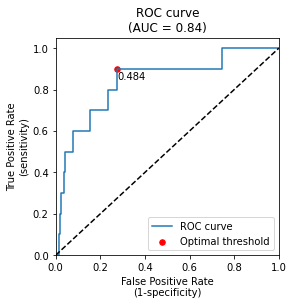

In [172]:
fig, axs = plt.subplots(ncols=1, figsize=(4,4))
for idx, roc in enumerate([roc_all_observed]):
    binary_roc_curve_draw(roc, axs)
plt.show()

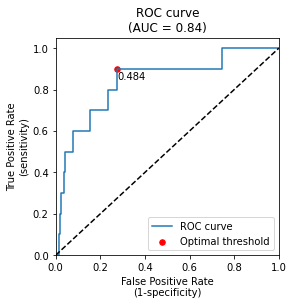

In [173]:
fig, axs = plt.subplots(ncols=1, figsize=(4,4))
for idx, roc in enumerate([roc_all_observed_l2]):
    binary_roc_curve_draw(roc, axs)
plt.show()

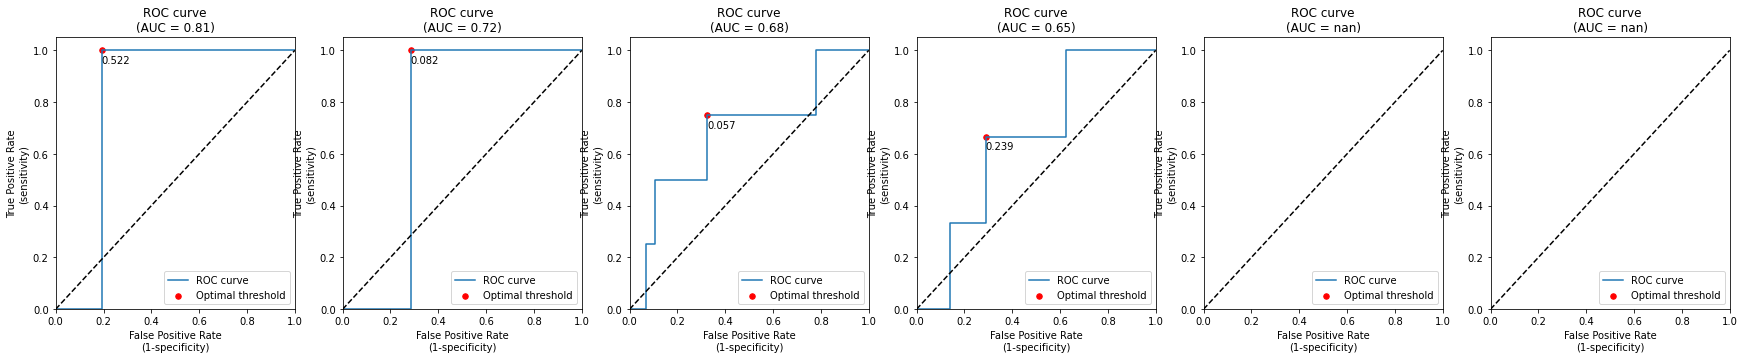

In [174]:
fig, axs = plt.subplots(ncols=selected_PC_num, figsize=(30,5))
for idx, roc in enumerate(roc_stack_period_observed):
    binary_roc_curve_draw(roc, axs[idx])
plt.show()

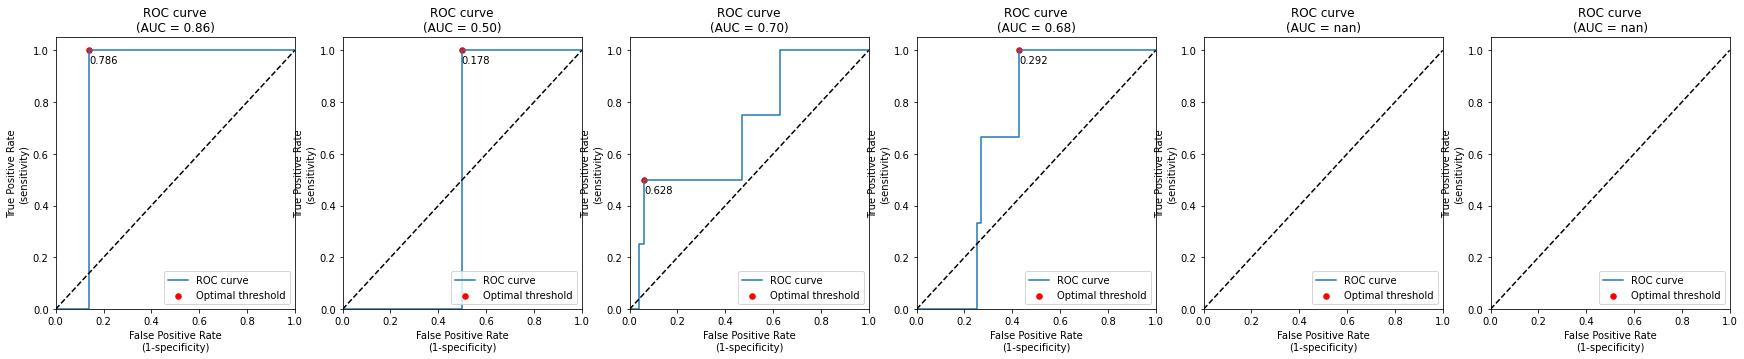

In [175]:
fig, axs = plt.subplots(ncols=selected_PC_num, figsize=(30,5))
for idx, roc in enumerate(roc_stack_period_pca):
    binary_roc_curve_draw(roc, axs[idx])
plt.show()

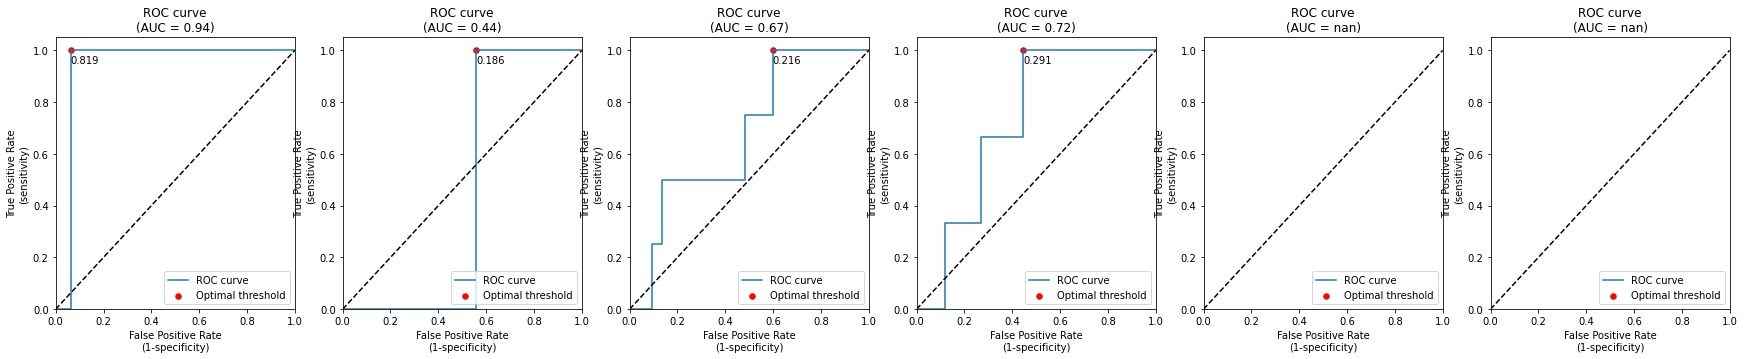

In [176]:
fig, axs = plt.subplots(ncols=selected_PC_num, figsize=(30,5))
for idx, roc in enumerate(roc_stack_period_fa):
    binary_roc_curve_draw(roc, axs[idx])
plt.show()

In [177]:
score_comparison = pd.concat([
    pd.DataFrame([score_all_observed]),
    pd.DataFrame([score_all_observed_l2]),
    pd.DataFrame(score_stack_period_observed),
    pd.DataFrame(score_stack_period_pca),
    pd.DataFrame(score_stack_period_fa),
])
score_comparison.index = [[
    'all-observed', 'all-observed-l2', 
    'period-observed', 'period-observed', 'period-observed', 'period-observed', 'period-observed', 'period-observed', 
    'period-pca', 'period-pca', 'period-pca', 'period-pca', 'period-pca', 'period-pca', 
    'period-fa', 'period-fa', 'period-fa', 'period-fa', 'period-fa', 'period-fa',
], ['-', '-'] + [f'Period {i+1}' for i in range(selected_PC_num)] + [f'Period {i+1}' for i in range(selected_PC_num)] + [f'Period {i+1}' for i in range(selected_PC_num)]]

score_comparison

accuracy  precision  recall     f1
all-observed    -           0.7440     0.0161  0.8000 0.0316
all-observed-l2 -           0.7440     0.0161  0.8000 0.0316
period-observed Period 1    0.8056     0.0175  1.0000 0.0345
                Period 2    0.8914     0.0000  0.0000 0.0000
                Period 3    0.8552     0.0308  0.5000 0.0580
                Period 4    0.8771     0.0000  0.0000 0.0000
                Period 5    0.8829     0.0000  0.0000 0.0000
                Period 6    1.0000     0.0000  0.0000 0.0000
period-pca      Period 1    0.5764     0.0081  1.0000 0.0161
                Period 2    0.7521     0.0000  0.0000 0.0000
                Period 3    0.8508     0.0299  0.5000 0.0563
                Period 4    0.8256     0.0000  0.0000 0.0000
                Period 5    0.8198     0.0000  0.0000 0.0000
                Period 6    1.0000     0.0000  0.0000 0.0000
period-fa       Period 1    0.4167     0.0059  1.0000 0.0118
                Period 2    0.7577     0.0000  0.0000 0.0000
                Period 3    0.8463     0.0290  0.5000 0.0548
                Period 4    0.8477     0.0164  0.3333 0.0312
                Period 5    0.7898     0.0000  0.0000 0.0000
                Period 6    1.0000     0.0000  0.0000 0.0000

In [178]:
# confusion matricies

print('all-observed\n', conf_all_observed)
print('all-observed-l2\n', conf_all_observed_l2)

for i in range(len(conf_stack_period_observed)):
    print(f'period-observed-{i}\n', conf_stack_period_observed[i])

for i in range(len(conf_stack_period_pca)):
    print(f'period-pca-{i}\n', conf_stack_period_pca[i])

for i in range(len(conf_stack_period_fa)):
    print(f'period-fa-{i}\n', conf_stack_period_fa[i])

all-observed
 [[   8    2]
 [ 489 1419]]
all-observed-l2
 [[   8    2]
 [ 489 1419]]
period-fa-0
 [[  1   0]
 [168 119]]
period-fa-1
 [[  0   1]
 [ 86 272]]
period-fa-2
 [[  2   2]
 [ 67 378]]
period-fa-3
 [[  1   2]
 [ 60 344]]
period-fa-4
 [[  0   0]
 [ 70 263]]
period-fa-5
 [[ 0  0]
 [ 0 67]]


### 7. 서비스 적용

- 작업 대기열 데이터가 저장되어 있는 MySQL 데이터베이스로부터 자료를 가져와
- 작업자, 할당된 작업, 작업 환경 등의 변수를 모델에 입력하여 예측을 반환하면
- 사용자 웹페이지에서 작업자의 오류 확률을 기반으로 정보가 표시되는 서비스
- 프로토타입 수준으로만 구현

- 로지스틱 회귀에서 주의할 부분은 회귀계수의 해석
- 회귀계수는 오즈비(odds ratio)에 로그를 취한 값이므로, 지수(exponential)를 취해 오즈비로 변환하여 해석해야 함
$$ln \; \frac {p} {1-p} = -\gamma_0 -\gamma_1 z_{1i} \cdots -\gamma_k z_{ki}$$

- 오즈비는 (다른 변수의 효과가 일정한 경우) 해당 변수의 1단위 증가가 오류 발생(y=1) 확률을 몇 배 증가/감소시키는지 설명

In [179]:
# MySQL 데이터베이스 연결을 위한 크레덴셜 가져오기
import configparser
from google.colab import drive

drive.mount('/content/drive')
# !ls "/content/drive/My Drive"

CONFIG_PATH = '/content/drive/My Drive/credential.ini'
config = configparser.ConfigParser()
config.read(CONFIG_PATH, encoding='utf-8')

DB_USER = config['KURLY']['DB_USER']
DB_PASS = config['KURLY']['DB_PASS']
DB_HOST = config['KURLY']['DB_HOST']
DB_PORT = config['KURLY']['DB_PORT']
DB_DATABASE = config['KURLY']['DB_DATABASE']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [180]:
# MySQL 데이터베이스 조작을 위한 클래스
import pymysql

class MysqlConnection(object):

    def __init__(self, ssl_enable=False, cursor_type="Dict"):
        # Connection 필요요소
        self.__username = DB_USER
        self.__password = DB_PASS
        self.__hostip = DB_HOST
        self.__hostport = int(DB_PORT)
        self.__dbname = DB_DATABASE

        try:
            self.conn = pymysql.connect(
                host=self.__hostip, 
                port=self.__hostport,
                user=self.__username, 
                passwd=self.__password,
                db=db, 
                charset="utf8",
                local_infile=True) # local_infile: mysql에 파일을 곧바로 업로드하는 LOAD DATA/XML 명령에 필요

            if cursor_type == "Dict":
                curs = pymysql.cursors.DictCursor
            elif cursor_type == "Tuple":
                curs = ""
            self.cursor = self.conn.cursor(curs)
        except pymysql.err.OperationalError as e:
            print("Connection refused by server: ")
            print(e)

    def retreive_query(self, sql_query, fetch_size, execute_params=[], return_type="list_of_dict"):
        try:
            self.cursor.execute(sql_query, execute_params)
        except Exception as e:
            print("DB retreival failed. Reason:")
            print(e)
            print(sql_query)
            return

        if fetch_size == "All":
            result = self.cursor.fetchall()
        elif fetch_size == "One":
            result = self.cursor.fetchone()
        else:
            result = self.cursor.fetchmany(fetch_size)

        if result:
            return self.convert_return_datatype(result, return_type)
        else:
            return None

    def execute_query(self, sql_query, execute_params=[]):
        """
        execute DML(data manipulation languate) query.
        """
        try:
            # if param is a nested list of tuple
            if any(isinstance(i, tuple) for i in execute_params):
                self.cursor.executemany(sql_query, execute_params)
            else:
                self.cursor.execute(sql_query, execute_params)
            print('Query execution success. Query:')
            print(sql_query[:100] + ' ...')
        except Exception as e:
            print("Query execution failed. Reason:")
            print(e)
            print(sql_query)
            return None

        self.conn.commit()
        return

    def terminate_connection(self):
        try:
            self.conn.close()
        except:
            print('Tried to close connection, but No DB connection open.')

    @staticmethod
    def convert_return_datatype(return_data, return_type):
        if return_type == "list_of_tuple": # [(1, 2), (3, 4)]
            return zip(*[d.values() for d in return_data])

        elif return_type == "list_of_list": # [[1, 2], [3, 4]]
            return [list(col) for col in zip(*[d.values() for d in return_data])]

        elif return_type == "dict_of_list": # {'A': [1, 3], 'B': [2, 4]}
            return {k: [dic[k] for dic in return_data] for k in return_data[0]}

        else: # default: list of dict [{'A':1, 'B':2}, {'A':3, 'B':4}]
            return return_data